<h1 style="text-align: center;">Pitch Classification Model</h1>

## Necessary Libraries

In [1]:
import pandas as pd
import numpy as np
import joblib

## ML libraries
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from skopt import BayesSearchCV
from xgboost import XGBClassifier
from xgboost import plot_importance
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import log_loss, accuracy_score

## visalization libraries
import seaborn as sns
import plotly.express as px

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.patches as mpatches
from matplotlib.ticker import FuncFormatter
from matplotlib.patches import Patch

pd.options.display.max_columns = None
pd.set_option('display.float_format', '{:2f}'.format)

## Data Cleaning

In [219]:
def transform_tagged_pitches(pitch_type: str):
    """
    Maps the pitch of TaggedPitchType to be on the same wavelength as AutoPitchType
    """
    mapping = {'FourSeamFastBall': 'Four-Seam', 
               'Fastball': 'Four-Seam', 
               'TwoSeamFastBall': 'Sinker', 
               'ChangeUp': 'Changeup', 
               'Sweeper': 'Slider',
               'OneSeamFastBall': 'Sinker',
               }
    return mapping.get(pitch_type, pitch_type)

In [220]:
df = pd.read_csv('../../Files/merged_trackman_games.csv', dtype={'HomeTeamForeignID': str, 'AwayTeamForeignID': str}).drop(columns=['HomeTeamForeignID', 'AwayTeamForeignID']).copy()
# df = df[['Pitcher', 'PitcherThrows', 'PitcherTeam', 'TaggedPitchType', 'AutoPitchType', 
#          'RelSpeed', 'VertRelAngle', 'HorzRelAngle', 'SpinRate', 'SpinAxis', 'RelHeight', 'RelSide',
#          'Extension', 'InducedVertBreak', 'HorzBreak', 'VertApprAngle', 'HorzApprAngle']].copy()

## gets rid of the pitches without any data for it
df = df[~df['AutoPitchType'].isna()].reset_index(drop=True).copy()

## makes the pitch names be consistent
df['AutoPitchType'] = df.apply(lambda x: x['TaggedPitchType'] if x['AutoPitchType'] == 'Other' else x['AutoPitchType'], axis=1)
df['TaggedPitchType'] = df.apply(lambda x: 
                                 x['AutoPitchType'] 
                                 if (x['TaggedPitchType']=='Other' or x['TaggedPitchType']=='Knuckleball' or x['TaggedPitchType']=='Undefined')
                                 else x['TaggedPitchType'], axis=1)

df['TaggedPitchType'] = df['TaggedPitchType'].apply(transform_tagged_pitches)
df['AutoPitchType'] = df['AutoPitchType'].apply(transform_tagged_pitches)

## imputes the null values of Extension
df['Extension'] = df['Extension'].fillna(df.groupby(['Pitcher', 'PitcherThrows', 'PitcherTeam'])['Extension'].transform('mean'))
df['SpinRate'] = df['SpinRate'].fillna(df.groupby(['Pitcher', 'PitcherThrows', 'PitcherTeam', 'AutoPitchType'])['SpinRate'].transform('mean'))
## gets rid of any lingering null rows
df = df[~df['SpinRate'].isna()].reset_index(drop=True).copy()

df['PitcherThrows'] = df['PitcherThrows'].apply(lambda x: x=='Right').astype(int)
df

,PitchNo,Date,Time,PAofInning,PitchofPA,Pitcher,PitcherId,PitcherThrows,PitcherTeam,Batter,BatterId,BatterSide,BatterTeam,PitcherSet,Inning,Top/Bottom,Outs,Balls,Strikes,TaggedPitchType,AutoPitchType,PitchCall,KorBB,TaggedHitType,PlayResult,OutsOnPlay,RunsScored,RelSpeed,VertRelAngle,HorzRelAngle,SpinRate,SpinAxis,Tilt,RelHeight,RelSide,Extension,VertBreak,InducedVertBreak,HorzBreak,PlateLocHeight,PlateLocSide,ZoneSpeed,VertApprAngle,HorzApprAngle,ZoneTime,ExitSpeed,Angle,Direction,HitSpinRate,PositionAt110X,PositionAt110Y,PositionAt110Z,Distance,LastTrackedDistance,Bearing,HangTime,pfxx,pfxz,x0,y0,z0,vx0,vy0,vz0,ax0,ay0,az0,HomeTeam,AwayTeam,Stadium,Level,League,GameID,PitchUID,EffectiveVelo,MaxHeight,MeasuredDuration,SpeedDrop,PitchLastMeasuredX,PitchLastMeasuredY,PitchLastMeasuredZ,ContactPositionX,ContactPositionY,ContactPositionZ,GameUID,UTCDate,UTCTime,LocalDateTime,UTCDateTime,AutoHitType,System,GameForeignID,Catcher,CatcherId,CatcherThrows,CatcherTeam,PlayID,PitchTrajectoryXc0,PitchTrajectoryXc1,PitchTrajectoryXc2,PitchTrajectoryYc0,PitchTrajectoryYc1,PitchTrajectoryYc2,PitchTrajectoryZc0,PitchTrajectoryZc1,PitchTrajectoryZc2,HitSpinAxis,HitTrajectoryXc0,HitTrajectoryXc1,HitTrajectoryXc2,HitTrajectoryXc3,HitTrajectoryXc4,HitTrajectoryXc5,HitTrajectoryXc6,HitTrajectoryXc7,HitTrajectoryXc8,HitTrajectoryYc0,HitTrajectoryYc1,HitTrajectoryYc2,HitTrajectoryYc3,HitTrajectoryYc4,HitTrajectoryYc5,HitTrajectoryYc6,HitTrajectoryYc7,HitTrajectoryYc8,HitTrajectoryZc0,HitTrajectoryZc1,HitTrajectoryZc2,HitTrajectoryZc3,HitTrajectoryZc4,HitTrajectoryZc5,HitTrajectoryZc6,HitTrajectoryZc7,HitTrajectoryZc8,ThrowSpeed,PopTime,ExchangeTime,TimeToBase,CatchPositionX,CatchPositionY,CatchPositionZ,ThrowPositionX,ThrowPositionY,ThrowPositionZ,BasePositionX,BasePositionY,BasePositionZ,ThrowTrajectoryXc0,ThrowTrajectoryXc1,ThrowTrajectoryXc2,ThrowTrajectoryYc0,ThrowTrajectoryYc1,ThrowTrajectoryYc2,ThrowTrajectoryZc0,ThrowTrajectoryZc1,ThrowTrajectoryZc2,PitchReleaseConfidence,PitchLocationConfidence,PitchMovementConfidence,HitLaunchConfidence,HitLandingConfidence,CatcherThrowCatchConfidence,CatcherThrowReleaseConfidence,CatcherThrowLocationConfidence
0,1,2025-03-25,18:08:29.92,1,1,"Martin, Landon",1000364953.000,1,CAL_FUL,"Watson, Rex",1000336187.000,Left,SAN_TOR,Undefined,1,Top,0,0,0,Four-Seam,Four-Seam,InPlay,Undefined,Popup,Out,1,0,88.862,-1.467,-1.379,1973.863,199.693,12:45,5.821,0.886,5.865,-20.138,15.629,5.148,2.779,0.033,80.488,-5.280,-0.456,0.430,82.051,73.609,-26.910,NaN,NaN,NaN,NaN,NaN,34.694,NaN,NaN,-3.077,8.823,-0.777,50.000,5.690,2.888,-128.911,-3.921,-5.120,29.559,-17.491,CAL_FUL,SAN_TOR,GoodwinField,D1,BW,20250325-GoodwinField-1,d4cb7a60-09de-11f0-91ec-41cc551cf82d,87.568,110.070,NaN,8.374,NaN,NaN,NaN,0.665,3.162,-0.649,4f69f254-7555-401e-b034-118e07d33b1e,2025-03-26,01:08:29.92,2025-03-25T18:08:29.9246592-07:00,2025-03-26T01:08:29.9246592Z,NaN,v3,25 March 2025 21:00-sandiego@calstfull,"Ortega, Max",703672,Right,CAL_FUL,dc341f6c-8981-4044-addd-07f5b0d70724,54.634,-129.969,14.780,5.819,-3.295,-8.746,-0.884,3.071,-2.560,NaN,0.665,30.278,-13.003,3.701,-0.222,-0.459,0.202,0.032,-0.029,3.162,115.450,-29.526,3.837,-0.860,0.297,-0.134,0.041,-0.005,-0.649,-15.373,-3.675,1.439,0.006,-0.326,0.150,0.007,-0.015,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,High,High,High,Medium,Undefined,NaN,NaN,NaN
1,2,2025-03-25,18:09:07.68,2,1,"Martin, Landon",1000364953.000,1,CAL_FUL,"Libed, Nico",822297.000,Right,SAN_TOR,Undefined,1,Top,1,0,0,Four-Seam,Four-Seam,StrikeCalled,Undefined,Undefined,Undefined,0,0,88.807,-2.888,-1.987,2086.802,201.089,12:45,5.809,0.922,5.797,-19.778,16.168,5.751,1.471,-0.448,80.641,-6.616,-0.957,0.432,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-3.559,9.512,-0.762,50.000,5.560,4.223,-128.673,-7.107,-5.910,29.078,-16.378,CAL_FUL,SAN_TOR,GoodwinField,D1,BW,20250325-GoodwinField-1,eb4f2e30-09de-11f0-91ec-41cc551cf82d,87.349,NaN,NaN,8.165,NaN,NaN,NaN,NaN,NaN,NaN,4f69f254-7555-401e-b034-118

In [221]:
display(df['TaggedPitchType'].unique())
display(df['AutoPitchType'].unique())
display(df.isna().sum())

array(['Four-Seam', 'Slider', 'Curveball', 'Sinker', 'Changeup',
       'Splitter', 'Cutter'], dtype=object)

array(['Four-Seam', 'Slider', 'Curveball', 'Cutter', 'Changeup', 'Sinker',
       'Splitter'], dtype=object)

PitchNo                               0
Date                                  0
Time                                  0
PAofInning                            0
PitchofPA                             0
                                  ...  
HitLaunchConfidence               25589
HitLandingConfidence              25589
CatcherThrowCatchConfidence       34567
CatcherThrowReleaseConfidence     34567
CatcherThrowLocationConfidence    34567
Length: 164, dtype: int64

## EDA

In [222]:
def pitch_type_group(pitch_type: str):
    """
    Maps out the pitch type and outputs its pitch group (e.g., 4S are fastballs, SL are breaking balls, etc.)
    """
    pitch_groups = {'Fastball': ['Sinker', 'Four-Seam', 'Cutter'],
                    'Breakingball': ['Slider', 'Curveball'],
                    'Offspeed': ['Changeup', 'Splitter']
                    }
    for k, v in pitch_groups.items():
        if pitch_type in v:
            return k
    return np.nan

In [223]:
## finds the pitch groups from each classification system
df['TaggedGroup'] = df['TaggedPitchType'].apply(pitch_type_group)
df['AutoGroup'] = df['AutoPitchType'].apply(pitch_type_group)

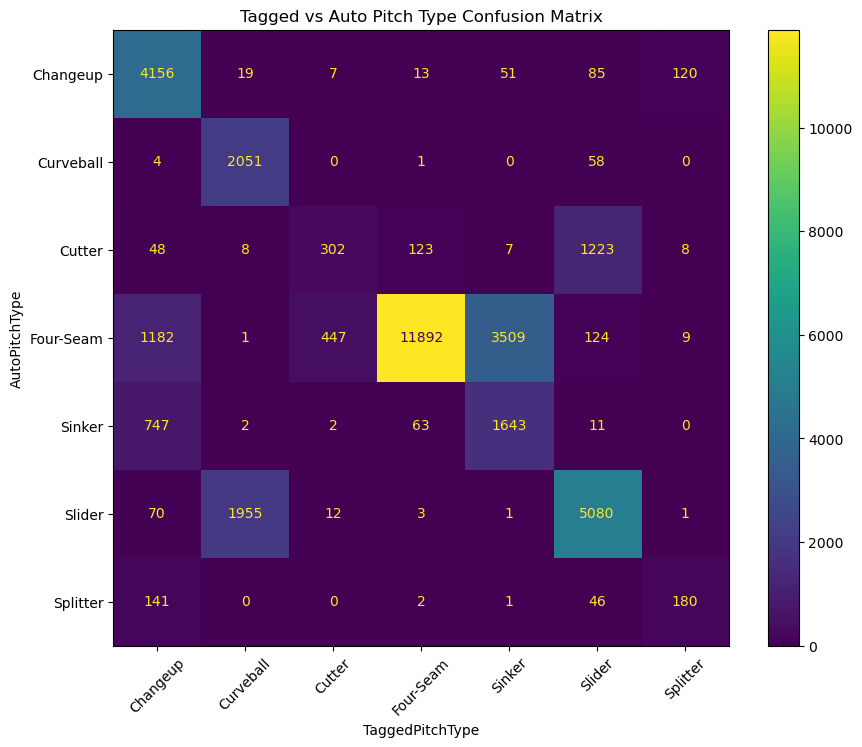

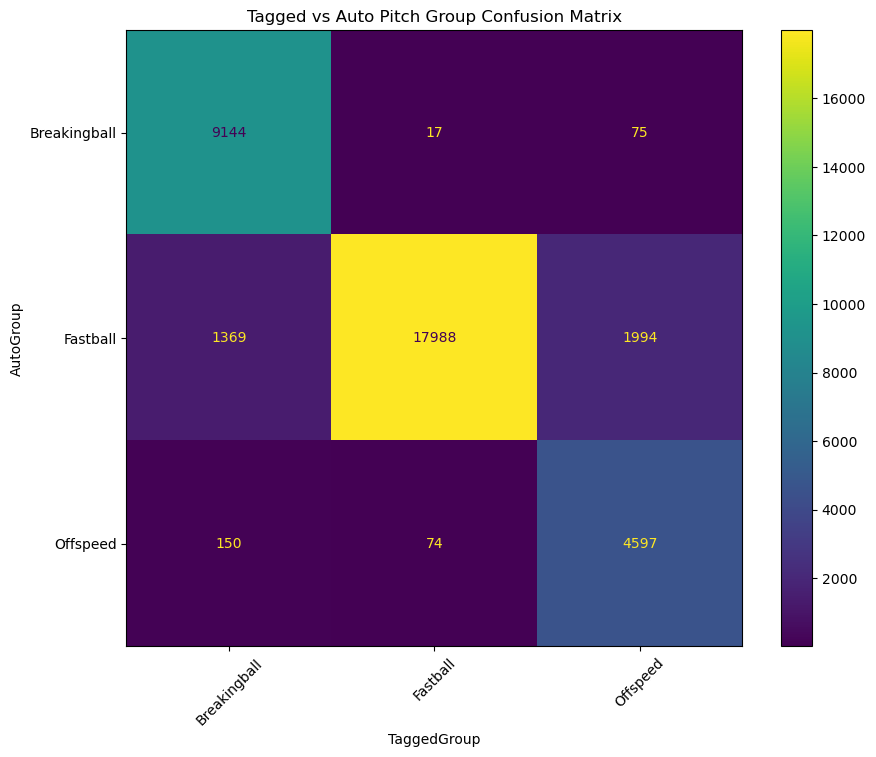

In [224]:
## individual pitches
labels = sorted(set(df["TaggedPitchType"].unique()) | set(df["AutoPitchType"].unique()))
cm = confusion_matrix(df["TaggedPitchType"], df["AutoPitchType"], labels=labels)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
fig, ax = plt.subplots(figsize=(10, 8))
disp.plot(ax=ax, xticks_rotation=45, cmap=plt.cm.viridis)
ax.set_xlabel("TaggedPitchType")
ax.set_ylabel("AutoPitchType")
plt.title("Tagged vs Auto Pitch Type Confusion Matrix")
plt.show()

## pitch groups
group_labels = sorted(set(df["TaggedGroup"].unique()) | set(df["AutoGroup"].unique()))
group_cm = confusion_matrix(df["TaggedGroup"], df["AutoGroup"], labels=group_labels)
group_disp = ConfusionMatrixDisplay(confusion_matrix=group_cm, display_labels=group_labels)
fig, ax = plt.subplots(figsize=(10, 8))
group_disp.plot(ax=ax, xticks_rotation=45, cmap=plt.cm.viridis)
ax.set_xlabel("TaggedGroup")
ax.set_ylabel("AutoGroup")
plt.title("Tagged vs Auto Pitch Group Confusion Matrix")
plt.show()

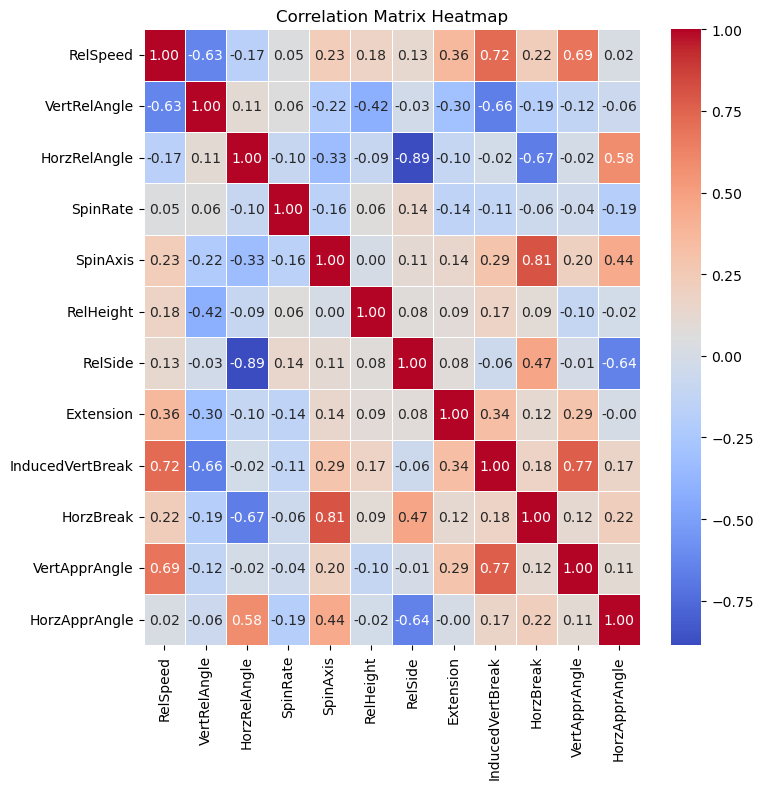

In [225]:
plt.figure(figsize=(8, 8)) 
correlation_matrix = df[['RelSpeed', 'VertRelAngle', 'HorzRelAngle', 'SpinRate', 'SpinAxis', 'RelHeight', 'RelSide', 
                         'Extension', 'InducedVertBreak', 'HorzBreak', 'VertApprAngle', 'HorzApprAngle']].corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5)
plt.title('Correlation Matrix Heatmap')
plt.show()

In [226]:
training_data = df[df['TaggedGroup'] == df['AutoGroup']].reset_index(drop=True).copy()
training_data

,PitchNo,Date,Time,PAofInning,PitchofPA,Pitcher,PitcherId,PitcherThrows,PitcherTeam,Batter,BatterId,BatterSide,BatterTeam,PitcherSet,Inning,Top/Bottom,Outs,Balls,Strikes,TaggedPitchType,AutoPitchType,PitchCall,KorBB,TaggedHitType,PlayResult,OutsOnPlay,RunsScored,RelSpeed,VertRelAngle,HorzRelAngle,SpinRate,SpinAxis,Tilt,RelHeight,RelSide,Extension,VertBreak,InducedVertBreak,HorzBreak,PlateLocHeight,PlateLocSide,ZoneSpeed,VertApprAngle,HorzApprAngle,ZoneTime,ExitSpeed,Angle,Direction,HitSpinRate,PositionAt110X,PositionAt110Y,PositionAt110Z,Distance,LastTrackedDistance,Bearing,HangTime,pfxx,pfxz,x0,y0,z0,vx0,vy0,vz0,ax0,ay0,az0,HomeTeam,AwayTeam,Stadium,Level,League,GameID,PitchUID,EffectiveVelo,MaxHeight,MeasuredDuration,SpeedDrop,PitchLastMeasuredX,PitchLastMeasuredY,PitchLastMeasuredZ,ContactPositionX,ContactPositionY,ContactPositionZ,GameUID,UTCDate,UTCTime,LocalDateTime,UTCDateTime,AutoHitType,System,GameForeignID,Catcher,CatcherId,CatcherThrows,CatcherTeam,PlayID,PitchTrajectoryXc0,PitchTrajectoryXc1,PitchTrajectoryXc2,PitchTrajectoryYc0,PitchTrajectoryYc1,PitchTrajectoryYc2,PitchTrajectoryZc0,PitchTrajectoryZc1,PitchTrajectoryZc2,HitSpinAxis,HitTrajectoryXc0,HitTrajectoryXc1,HitTrajectoryXc2,HitTrajectoryXc3,HitTrajectoryXc4,HitTrajectoryXc5,HitTrajectoryXc6,HitTrajectoryXc7,HitTrajectoryXc8,HitTrajectoryYc0,HitTrajectoryYc1,HitTrajectoryYc2,HitTrajectoryYc3,HitTrajectoryYc4,HitTrajectoryYc5,HitTrajectoryYc6,HitTrajectoryYc7,HitTrajectoryYc8,HitTrajectoryZc0,HitTrajectoryZc1,HitTrajectoryZc2,HitTrajectoryZc3,HitTrajectoryZc4,HitTrajectoryZc5,HitTrajectoryZc6,HitTrajectoryZc7,HitTrajectoryZc8,ThrowSpeed,PopTime,ExchangeTime,TimeToBase,CatchPositionX,CatchPositionY,CatchPositionZ,ThrowPositionX,ThrowPositionY,ThrowPositionZ,BasePositionX,BasePositionY,BasePositionZ,ThrowTrajectoryXc0,ThrowTrajectoryXc1,ThrowTrajectoryXc2,ThrowTrajectoryYc0,ThrowTrajectoryYc1,ThrowTrajectoryYc2,ThrowTrajectoryZc0,ThrowTrajectoryZc1,ThrowTrajectoryZc2,PitchReleaseConfidence,PitchLocationConfidence,PitchMovementConfidence,HitLaunchConfidence,HitLandingConfidence,CatcherThrowCatchConfidence,CatcherThrowReleaseConfidence,CatcherThrowLocationConfidence,TaggedGroup,AutoGroup
0,1,2025-03-25,18:08:29.92,1,1,"Martin, Landon",1000364953.000,1,CAL_FUL,"Watson, Rex",1000336187.000,Left,SAN_TOR,Undefined,1,Top,0,0,0,Four-Seam,Four-Seam,InPlay,Undefined,Popup,Out,1,0,88.862,-1.467,-1.379,1973.863,199.693,12:45,5.821,0.886,5.865,-20.138,15.629,5.148,2.779,0.033,80.488,-5.280,-0.456,0.430,82.051,73.609,-26.910,NaN,NaN,NaN,NaN,NaN,34.694,NaN,NaN,-3.077,8.823,-0.777,50.000,5.690,2.888,-128.911,-3.921,-5.120,29.559,-17.491,CAL_FUL,SAN_TOR,GoodwinField,D1,BW,20250325-GoodwinField-1,d4cb7a60-09de-11f0-91ec-41cc551cf82d,87.568,110.070,NaN,8.374,NaN,NaN,NaN,0.665,3.162,-0.649,4f69f254-7555-401e-b034-118e07d33b1e,2025-03-26,01:08:29.92,2025-03-25T18:08:29.9246592-07:00,2025-03-26T01:08:29.9246592Z,NaN,v3,25 March 2025 21:00-sandiego@calstfull,"Ortega, Max",703672,Right,CAL_FUL,dc341f6c-8981-4044-addd-07f5b0d70724,54.634,-129.969,14.780,5.819,-3.295,-8.746,-0.884,3.071,-2.560,NaN,0.665,30.278,-13.003,3.701,-0.222,-0.459,0.202,0.032,-0.029,3.162,115.450,-29.526,3.837,-0.860,0.297,-0.134,0.041,-0.005,-0.649,-15.373,-3.675,1.439,0.006,-0.326,0.150,0.007,-0.015,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,High,High,High,Medium,Undefined,NaN,NaN,NaN,Fastball,Fastball
1,2,2025-03-25,18:09:07.68,2,1,"Martin, Landon",1000364953.000,1,CAL_FUL,"Libed, Nico",822297.000,Right,SAN_TOR,Undefined,1,Top,1,0,0,Four-Seam,Four-Seam,StrikeCalled,Undefined,Undefined,Undefined,0,0,88.807,-2.888,-1.987,2086.802,201.089,12:45,5.809,0.922,5.797,-19.778,16.168,5.751,1.471,-0.448,80.641,-6.616,-0.957,0.432,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-3.559,9.512,-0.762,50.000,5.560,4.223,-128.673,-7.107,-5.910,29.078,-16.378,CAL_FUL,SAN_TOR,GoodwinField,D1,BW,20250325-GoodwinField-1,eb4f2e30-09de-11f0-91ec-41cc551cf82d,87.349,NaN,NaN,8.165,NaN,NaN,NaN

In [227]:
## 4-seam fastballs
training_data[training_data['TaggedPitchType']=='Four-Seam'][['RelSpeed', 'SpinRate', 'SpinAxis', 'InducedVertBreak', 'HorzBreak', 'RelHeight', 'RelSide']].describe()

,RelSpeed,SpinRate,SpinAxis,InducedVertBreak,HorzBreak,RelHeight,RelSide
count,15848.000,15848.000,15848.000,15848.000,15848.000,15848.000,15848.000
mean,89.984,2228.257,188.508,18.288,2.856,5.895,0.441
std,2.776,159.113,33.028,4.022,11.064,0.453,1.604
min,80.664,1602.679,82.149,-15.139,-26.489,2.359,-3.594
25%,88.028,2120.596,156.262,15.941,-7.781,5.646,-1.183
50%,89.696,2224.941,199.198,18.698,6.380,5.899,1.061
75%,91.583,2339.294,212.999,21.099,11.531,6.177,1.665
max,100.263,2746.632,343.373,37.689,25.549,7.190,4.860


In [228]:
## Sinkers
training_data[training_data['TaggedPitchType']=='Sinker'][['RelSpeed', 'SpinRate', 'SpinAxis', 'InducedVertBreak', 'HorzBreak', 'RelHeight', 'RelSide']].describe()

,RelSpeed,SpinRate,SpinAxis,InducedVertBreak,HorzBreak,RelHeight,RelSide
count,1708.000,1708.000,1708.000,1708.000,1708.000,1708.000,1708.000
mean,90.179,2121.937,196.403,9.553,4.610,5.438,0.568
std,1.925,162.821,64.794,4.329,17.913,0.491,1.975
min,84.131,1601.265,63.876,-9.042,-28.516,3.461,-3.800
25%,88.896,2022.895,120.642,7.393,-17.254,5.147,-1.461
50%,90.005,2128.164,235.711,10.190,16.054,5.512,1.638
75%,91.380,2231.270,247.485,12.476,19.179,5.770,2.118
max,96.763,2679.749,302.610,23.703,27.921,6.713,3.794


In [229]:
## cutters
training_data[training_data['TaggedPitchType']=='Cutter'][['RelSpeed', 'SpinRate', 'SpinAxis', 'InducedVertBreak', 'HorzBreak', 'RelHeight', 'RelSide']].describe()

,RelSpeed,SpinRate,SpinAxis,InducedVertBreak,HorzBreak,RelHeight,RelSide
count,432.000,432.000,432.000,432.000,432.000,432.000,432.000
mean,87.717,2311.629,187.397,11.704,1.395,6.037,-0.122
std,2.687,156.573,19.714,2.866,3.660,0.436,1.823
min,80.704,1845.053,136.812,5.023,-9.042,4.718,-2.447
25%,85.936,2214.986,174.370,9.955,-1.193,5.739,-2.004
50%,87.837,2321.013,187.800,11.514,1.477,5.945,0.679
75%,89.389,2407.324,199.270,13.381,3.673,6.376,1.633
max,95.908,2735.148,243.794,25.725,13.105,6.960,3.433


In [230]:
## changeups
training_data[training_data['TaggedPitchType']=='Changeup'][['RelSpeed', 'SpinRate', 'SpinAxis', 'InducedVertBreak', 'HorzBreak', 'RelHeight', 'RelSide']].describe()

,RelSpeed,SpinRate,SpinAxis,InducedVertBreak,HorzBreak,RelHeight,RelSide
count,4276.000,4276.000,4276.000,4276.000,4276.000,4276.000,4276.000
mean,80.710,1796.325,191.270,7.798,3.046,5.687,0.293
std,3.346,361.220,70.401,5.165,16.370,0.434,1.877
min,66.097,725.462,30.675,-9.752,-27.354,3.562,-3.764
25%,77.949,1523.243,114.975,4.214,-14.600,5.460,-1.667
50%,80.689,1778.573,230.342,8.137,11.875,5.654,1.238
75%,83.384,2062.017,250.812,11.377,17.512,5.916,1.845
max,90.409,2745.807,334.989,25.227,27.751,6.963,3.701


In [231]:
## splitters
training_data[training_data['TaggedPitchType']=='Splitter'][['RelSpeed', 'SpinRate', 'SpinAxis', 'InducedVertBreak', 'HorzBreak', 'RelHeight', 'RelSide']].describe()

,RelSpeed,SpinRate,SpinAxis,InducedVertBreak,HorzBreak,RelHeight,RelSide
count,321.000,321.000,321.000,321.000,321.000,321.000,321.000
mean,82.582,1178.965,243.907,4.644,10.085,5.678,1.597
std,2.974,260.477,49.580,5.641,7.874,0.373,1.185
min,75.286,714.195,4.455,-14.311,-19.192,4.592,-2.707
25%,80.315,976.383,236.165,0.957,8.994,5.527,1.485
50%,81.893,1102.918,250.631,5.118,12.311,5.778,2.018
75%,85.384,1422.062,272.653,8.422,14.640,5.901,2.235
max,88.366,2301.875,324.893,18.999,20.103,7.119,2.976


In [232]:
## Curveballs
training_data[training_data['TaggedPitchType']=='Curveball'][['RelSpeed', 'SpinRate', 'SpinAxis', 'InducedVertBreak', 'HorzBreak', 'RelHeight', 'RelSide']].describe()

,RelSpeed,SpinRate,SpinAxis,InducedVertBreak,HorzBreak,RelHeight,RelSide
count,2109.000,2109.000,2109.000,2109.000,2109.000,2109.000,2109.000
mean,76.029,2425.301,95.318,-11.673,-6.224,5.974,0.850
std,4.088,274.793,116.685,5.183,9.325,0.395,1.266
min,61.911,1666.164,0.334,-26.981,-26.031,4.574,-3.030
25%,73.921,2230.381,27.802,-15.356,-12.952,5.687,0.343
50%,76.274,2419.594,42.431,-11.243,-8.428,5.968,1.111
75%,78.743,2635.884,62.979,-8.005,-2.495,6.298,1.714
max,88.037,3343.170,359.794,6.821,24.577,6.943,3.498


In [233]:
## Sliders
training_data[training_data['TaggedPitchType']=='Slider'][['RelSpeed', 'SpinRate', 'SpinAxis', 'InducedVertBreak', 'HorzBreak', 'RelHeight', 'RelSide']].describe()

,RelSpeed,SpinRate,SpinAxis,InducedVertBreak,HorzBreak,RelHeight,RelSide
count,7035.000,7035.000,7035.000,7035.000,7035.000,7035.000,7035.000
mean,80.000,2386.062,152.702,1.143,-2.588,5.628,0.613
std,3.340,242.174,90.796,4.950,10.167,0.511,1.795
min,63.053,1044.018,0.063,-18.933,-27.041,2.938,-3.997
25%,77.753,2219.519,78.714,-2.068,-9.531,5.396,-1.030
50%,80.078,2390.272,117.220,1.443,-3.892,5.670,1.321
75%,82.385,2554.773,247.719,4.532,5.162,5.933,1.941
max,89.505,3445.186,359.887,19.556,28.547,7.062,4.916


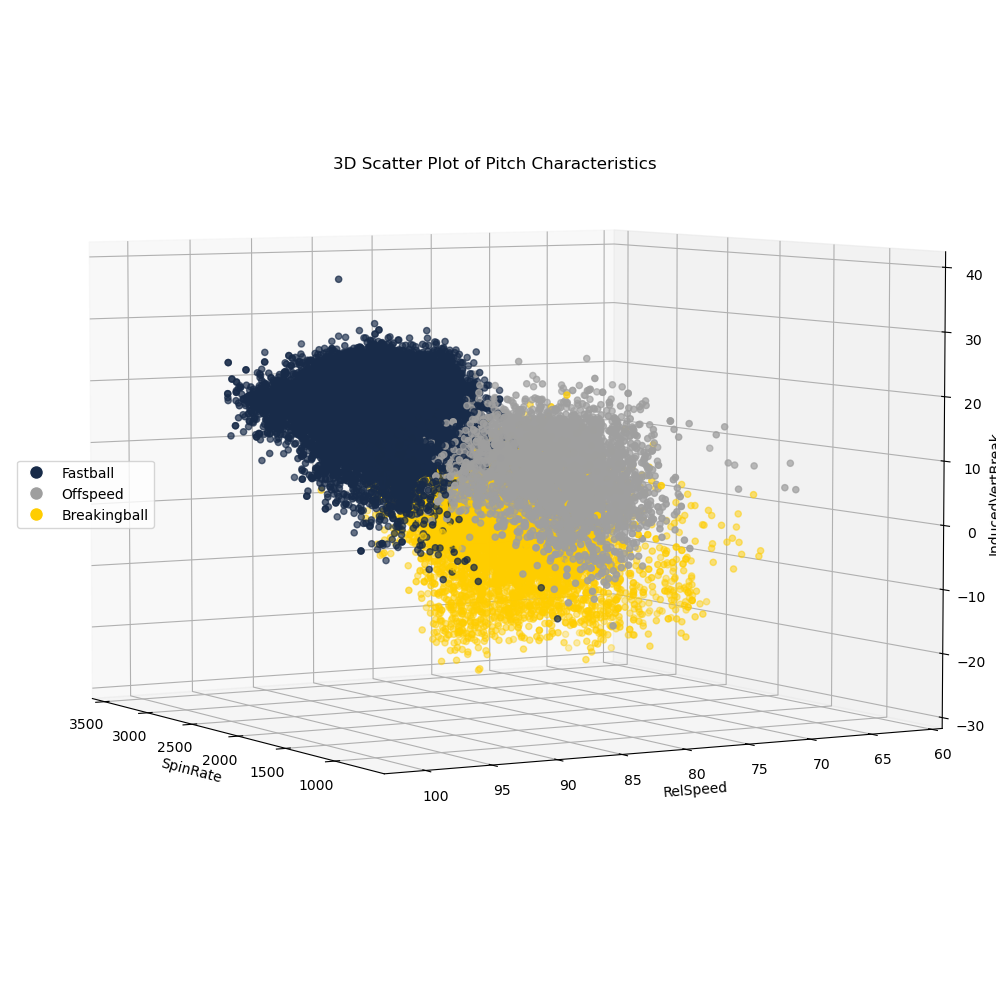

In [234]:
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.lines import Line2D

colors = training_data['AutoGroup'].map({'Breakingball': '#FFCD00', 'Fastball': '#182B49', 'Offspeed': '#9f9f9f'})

legend_elements = [Line2D([0], [0], marker='o', color='w', label='Fastball', markerfacecolor='#182B49', markersize=10), 
                   Line2D([0], [0], marker='o', color='w', label='Offspeed', markerfacecolor='#9f9f9f', markersize=10),
                   Line2D([0], [0], marker='o', color='w', label='Breakingball', markerfacecolor='#FFCD00', markersize=10),
                   ]

fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(projection='3d')
ax.scatter(training_data['SpinRate'], training_data['RelSpeed'], training_data['InducedVertBreak'], c=colors, marker='o')
ax.set_xlabel('SpinRate')
ax.set_ylabel('RelSpeed')
ax.set_zlabel('InducedVertBreak', labelpad=0)
ax.set_title('3D Scatter Plot of Pitch Characteristics', y=0.9)
ax.view_init(elev=5, azim=150)
ax.legend(handles=legend_elements, loc='center left')
plt.tight_layout()
plt.show()

## Pitch Group Model

Setting up the training set

In [235]:
group_training_data = training_data.copy()
group_training_data['group_cat_code'] = group_training_data['TaggedGroup'].astype('category').cat.codes
group_training_data['pitch_cat_code'] = group_training_data['TaggedPitchType'].astype('category').cat.codes

In [236]:
lhp = group_training_data[group_training_data['PitcherThrows']==0].reset_index(drop=True).copy()
group_X_lhp = (lhp[['RelSpeed', 'SpinRate', 'SpinAxis', 'InducedVertBreak', 'HorzBreak', 'RelHeight', 'RelSide']]
               .transform(lambda x: (x-x.mean()) / x.std())
               ).values
group_y_lhp = lhp['group_cat_code'].values

rhp = group_training_data[group_training_data['PitcherThrows']==1].reset_index(drop=True).copy()
group_X_rhp = (rhp[['RelSpeed', 'SpinRate', 'SpinAxis', 'InducedVertBreak', 'HorzBreak', 'RelHeight', 'RelSide']]
               .transform(lambda x: (x-x.mean()) / x.std())
               ).values
group_y_rhp = rhp['group_cat_code'].values

In [237]:
def xgboost_model(X, y):
    """
    Using an xgboost classifier model with bayesian optimization hypertuning to classify pitch type
    """
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.1, stratify=y, random_state=42)
    xgb = XGBClassifier(objective="multi:softprob", num_class=3, eval_metric="mlogloss", tree_method="hist", random_state=42)

    param_grid = {"n_estimators": (100, 500), ## num of trees in the model
                "learning_rate": (0.01, 0.3, "log-uniform"), ## the rate at which the model makes changes to the weights
                "max_depth": (3, 7), ## how deep the trees can be
                "min_child_weight": (0.1, 5, "log-uniform"), ## min num of obs can be present in each node of the tree
                "subsample": (0.7, 0.9), ## num of obs used to build each tree
                "colsample_bytree": (0.6, 1.0), ## num of features used to build each tree
                "reg_alpha": (1e-2, 1, "log-uniform"), ## controls the strength of regularization (l1)
                "reg_lambda": (1e-2, 1, "log-uniform"), ## controls the strength of regularization (l2)
                "gamma": (0.0, 2.0), ## min loss reduction required to make a split
                }

    ## 3-fold stratified cv with bayesian optimization hypertuning to find the best xgboost model
    cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)
    opt = BayesSearchCV(estimator=xgb, search_spaces=param_grid, n_iter=20, cv=cv, n_jobs=-1, scoring="neg_log_loss", verbose=0, random_state=42, refit=True)
    opt.fit(X_train, y_train)

    ## final training with validation split: checking generalization
    best_xgb = opt.best_estimator_
    best_xgb.fit(X_train, y_train, eval_set=[(X_val, y_val)], verbose=False)

    y_val_prob = best_xgb.predict_proba(X_val)
    y_val_pred = best_xgb.predict(X_val)

    ## evaluation metrics
    print("Log loss:", log_loss(y_val, y_val_prob))
    print("Accuracy:", accuracy_score(y_val, y_val_pred))

    ## confusion matrix for the model's results
    cat_dtype = group_training_data['TaggedGroup'].astype('category')
    class_names = cat_dtype.cat.categories.tolist()
    xgb_cm = confusion_matrix(y_val, y_val_pred)
    xgb_disp = ConfusionMatrixDisplay(confusion_matrix=xgb_cm, display_labels=class_names)
    fig, ax = plt.subplots(figsize=(10, 8))
    xgb_disp.plot(ax=ax, xticks_rotation=45, cmap=plt.cm.viridis)
    ax.set_xlabel("Predicted")
    ax.set_ylabel("Actual")
    plt.title("XGBoost Validation Confusion Matrix")
    plt.show()

    ## displays the importance of each feature used (# is the # of times each feature is used in splits across the trees)
    feature_names = ['RelSpeed', 'SpinRate', 'SpinAxis', 'InducedVertBreak', 'HorzBreak', 'RelHeight', 'RelSide']
    best_xgb.get_booster().feature_names = feature_names
    plot_importance(best_xgb, max_num_features=7)
    plt.show()

    return best_xgb

In [238]:
lhp_xgb = xgboost_model(group_X_lhp, group_y_lhp)

KeyboardInterrupt: 

Log loss: 0.014844849202269523
Accuracy: 0.9952244508118434


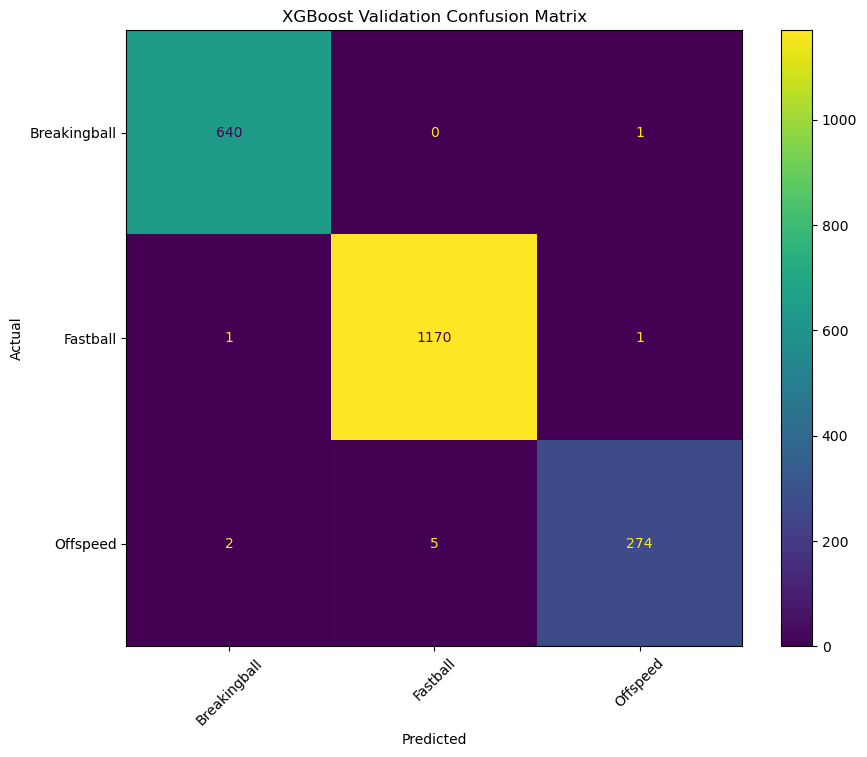

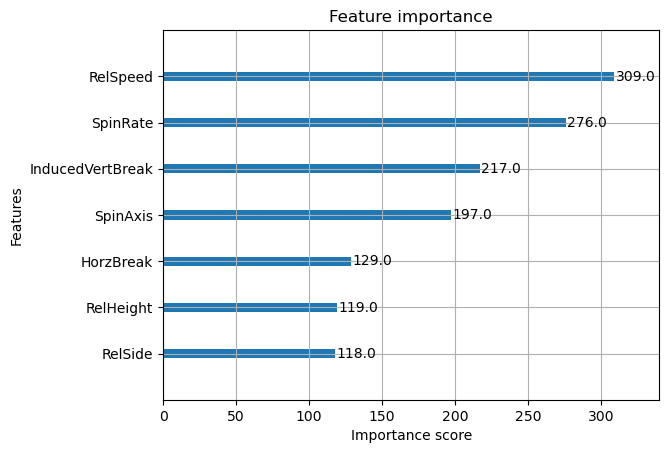

In [ ]:
rhp_xgb = xgboost_model(group_X_rhp, group_y_rhp)

Evaluating the model

In [ ]:
joblib.dump(lhp_xgb, "lhp_xgb.pkl")
lhp_xgb = joblib.load("lhp_xgb.pkl")
display(lhp_xgb)

joblib.dump(rhp_xgb, "rhp_xgb.pkl")
rhp_xgb = joblib.load("rhp_xgb.pkl")
display(rhp_xgb)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.9069493207263146, device=None,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric='mlogloss', feature_types=None, feature_weights=None,
              gamma=0.0, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.16340549599414553,
              max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=7, max_leaves=None,
              min_child_weight=0.1, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=370, n_jobs=None, num_class=3, ...)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.9933711875464454, device=None,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric='mlogloss', feature_types=None, feature_weights=None,
              gamma=0.378242967864947, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.29999999999999993,
              max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=5, max_leaves=None,
              min_child_weight=0.3551799059721739, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=500,
              n_jobs=None, num_class=3, ...)

In [ ]:
display(group_training_data
        .groupby(['group_cat_code', 'PitcherThrows'])[['RelSpeed', 'SpinRate', 'SpinAxis', 'InducedVertBreak', 'HorzBreak', 'RelHeight', 'RelSide']]
        .mean()
        )
display(group_training_data
        .groupby(['group_cat_code', 'PitcherThrows'])[['RelSpeed', 'SpinRate', 'SpinAxis', 'InducedVertBreak', 'HorzBreak', 'RelHeight', 'RelSide']]
        .std()
        )

RelSpeed     SpinRate    SpinAxis  \
group_cat_code PitcherThrows                                       
0              0              77.554514  2342.013781  268.128987   
               1              79.735809  2417.747691   84.618405   
1              0              88.696549  2167.682968  146.340383   
               1              90.617866  2248.272263  212.202808   
2              0              79.580160  1737.839943  110.623158   
               1              81.641677  1762.985160  248.520846   

                              InducedVertBreak  HorzBreak  RelHeight   RelSide  
group_cat_code PitcherThrows                                                    
0              0                     -0.168506   9.127588   5.602097 -1.662880  
               1                     -2.513807  -8.778120   5.753384  1.661471  
1              0                     16.653408 -11.068983   5.712550 -1.630060  
               1                     17.646394  10.516167   5.932003  1.548509  
2              0                      7.369029 -15.663792   5.552257 -1.834585  
               1                      7.710791  15.737077   5.772040  1.794129

RelSpeed    SpinRate   SpinAxis  \
group_cat_code PitcherThrows                                    
0              0              3.335780  231.439160  50.245910   
               1              3.945075  255.021584  56.698690   
1              0              2.142695  147.130242  21.221831   
               1              2.770779  164.205086  18.867940   
2              0              2.767923  367.442542  20.456324   
               1              3.448420  400.898803  21.406717   

                              InducedVertBreak  HorzBreak  RelHeight   RelSide  
group_cat_code PitcherThrows                                                    
0              0                      6.427582   5.769270   0.521369  0.802788  
               1                      7.618979   5.945910   0.494961  0.706177  
1              0                      4.882180   6.177264   0.493747  0.679049  
               1                      4.799415   5.516240   0.448598  0.644528  
2              0                      5.136321   4.921933   0.396775  0.602561  
               1                      5.334442   4.626889   0.428045  0.594254

In [ ]:
def prob_df(model, df, handedness, label_col="TaggedGroup"):
    """
    
    """
    X_pred_group = df[df['PitcherThrows'] == handedness].reset_index(drop=True).copy()
    
    cat_dtype = training_data[label_col].astype('category')
    classes = cat_dtype.cat.categories.tolist()
    
    X_pred_group['group_cat_code'] = training_data['TaggedGroup'].astype('category').cat.codes
    X_pred_group = (X_pred_group[['RelSpeed', 'SpinRate', 'SpinAxis', 'InducedVertBreak', 'HorzBreak', 'RelHeight', 'RelSide']].transform(lambda x: (x - x.mean()) / x.std()))
    probs = model.predict_proba(X_pred_group.values)
    class_labels = [classes[i] for i in model.classes_]
    probs_df = pd.DataFrame(probs, columns=[f"p_{c}" for c in class_labels])
    probs_df = probs_df.round(3)

    training_data_w_prob = pd.concat([df[df['PitcherThrows'] == handedness].reset_index(drop=True), probs_df], axis=1)
    
    return training_data_w_prob

In [ ]:
test_data = df[df['TaggedGroup'] != df['AutoGroup']].reset_index(drop=True).copy()
test_data

,PitchNo,Date,Time,PAofInning,PitchofPA,Pitcher,PitcherId,PitcherThrows,PitcherTeam,Batter,BatterId,BatterSide,BatterTeam,PitcherSet,Inning,Top/Bottom,Outs,Balls,Strikes,TaggedPitchType,AutoPitchType,PitchCall,KorBB,TaggedHitType,PlayResult,OutsOnPlay,RunsScored,RelSpeed,VertRelAngle,HorzRelAngle,SpinRate,SpinAxis,Tilt,RelHeight,RelSide,Extension,VertBreak,InducedVertBreak,HorzBreak,PlateLocHeight,PlateLocSide,ZoneSpeed,VertApprAngle,HorzApprAngle,ZoneTime,ExitSpeed,Angle,Direction,HitSpinRate,PositionAt110X,PositionAt110Y,PositionAt110Z,Distance,LastTrackedDistance,Bearing,HangTime,pfxx,pfxz,x0,y0,z0,vx0,vy0,vz0,ax0,ay0,az0,HomeTeam,AwayTeam,Stadium,Level,League,GameID,PitchUID,EffectiveVelo,MaxHeight,MeasuredDuration,SpeedDrop,PitchLastMeasuredX,PitchLastMeasuredY,PitchLastMeasuredZ,ContactPositionX,ContactPositionY,ContactPositionZ,GameUID,UTCDate,UTCTime,LocalDateTime,UTCDateTime,AutoHitType,System,GameForeignID,Catcher,CatcherId,CatcherThrows,CatcherTeam,PlayID,PitchTrajectoryXc0,PitchTrajectoryXc1,PitchTrajectoryXc2,PitchTrajectoryYc0,PitchTrajectoryYc1,PitchTrajectoryYc2,PitchTrajectoryZc0,PitchTrajectoryZc1,PitchTrajectoryZc2,HitSpinAxis,HitTrajectoryXc0,HitTrajectoryXc1,HitTrajectoryXc2,HitTrajectoryXc3,HitTrajectoryXc4,HitTrajectoryXc5,HitTrajectoryXc6,HitTrajectoryXc7,HitTrajectoryXc8,HitTrajectoryYc0,HitTrajectoryYc1,HitTrajectoryYc2,HitTrajectoryYc3,HitTrajectoryYc4,HitTrajectoryYc5,HitTrajectoryYc6,HitTrajectoryYc7,HitTrajectoryYc8,HitTrajectoryZc0,HitTrajectoryZc1,HitTrajectoryZc2,HitTrajectoryZc3,HitTrajectoryZc4,HitTrajectoryZc5,HitTrajectoryZc6,HitTrajectoryZc7,HitTrajectoryZc8,ThrowSpeed,PopTime,ExchangeTime,TimeToBase,CatchPositionX,CatchPositionY,CatchPositionZ,ThrowPositionX,ThrowPositionY,ThrowPositionZ,BasePositionX,BasePositionY,BasePositionZ,ThrowTrajectoryXc0,ThrowTrajectoryXc1,ThrowTrajectoryXc2,ThrowTrajectoryYc0,ThrowTrajectoryYc1,ThrowTrajectoryYc2,ThrowTrajectoryZc0,ThrowTrajectoryZc1,ThrowTrajectoryZc2,PitchReleaseConfidence,PitchLocationConfidence,PitchMovementConfidence,HitLaunchConfidence,HitLandingConfidence,CatcherThrowCatchConfidence,CatcherThrowReleaseConfidence,CatcherThrowLocationConfidence,TaggedGroup,AutoGroup
0,70,2025-03-25,18:48:46.87,5,4,"Horn, David",7.026150e+05,1,SAN_TOR,"Latta, Maddox",8.239440e+05,Right,CAL_FUL,Undefined,2,Bottom,2,2,1,Sinker,Changeup,BallCalled,Undefined,Undefined,Undefined,0,0,86.93549,-2.906844,-2.950047,1755.928970,231.326511,1:45,6.05073,0.51236,6.03091,-25.53001,11.72642,13.01351,1.22540,-1.13756,78.99813,-7.682912,-0.608986,0.439311,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-7.62792,7.31890,-0.28873,50.0,5.80936,5.96497,-125.91925,-7.19781,-12.11729,28.09687,-20.54768,CAL_FUL,SAN_TOR,GoodwinField,D1,BW,20250325-GoodwinField-1,75787f30-09e4-11f0-91ec-41cc551cf82d,85.79899,NaN,NaN,7.93736,NaN,NaN,NaN,NaN,NaN,NaN,4f69f254-7555-401e-b034-118e07d33b1e,2025-03-26,01:48:46.87,2025-03-25T18:48:46.8700000-07:00,2025-03-26T01:48:46.8700000Z,NaN,v3,25 March 2025 21:00-sandiego@calstfull,"Libed, Nico",822297,Right,SAN_TOR,60501b6c-ec3d-459d-aef1-e9711920d980,54.46817,-126.91234,14.04844,6.05094,-6.47155,-10.27384,-0.50713,6.39325,-6.05864,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,High,High,High,NaN,NaN,NaN,NaN,NaN,Fastball,Offspeed
1,73,2025-03-25,18:51:33.85,6,1,"Horn, David",7.026150e+05,1,SAN_TOR,"Kirchner, Andrew",1.000213e+09,Left,CAL_FUL,Undefined,2,Bottom,2,0,0,Four-Seam,Slider,BallCalled,Undefined,Undefined,Undefined,0,0,87.82298,1.188774,1.594113,2071.183221,158.285959,11:15,6.13399,0.50984,5.83308,-28.30415,8.20008,-2.78728,4.88089,1.75972,79.75143,-4.091422,1.094758,0.434854,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.88106,4.20961,-0.63833,50.0,6.21453,-3.42636,-127.42507,1.68882,3.07574,27.53432,-25.29095,CAL_FUL,SAN_TOR,GoodwinField,D1,BW,20250325-GoodwinField-1,d90062c0-09e4-11f0-91ec-41cc

## Individual Pitch Model

In [ ]:
merged_df = (pd.concat([prob_df(rhp_xgb, training_data, 1), 
                       prob_df(lhp_xgb, training_data, 0), 
                       prob_df(rhp_xgb, test_data, 1), 
                       prob_df(lhp_xgb, test_data, 0)])
                       .reset_index(drop=True)
                       .copy()
                       )
merged_df

,PitchNo,Date,Time,PAofInning,PitchofPA,Pitcher,PitcherId,PitcherThrows,PitcherTeam,Batter,BatterId,BatterSide,BatterTeam,PitcherSet,Inning,Top/Bottom,Outs,Balls,Strikes,TaggedPitchType,AutoPitchType,PitchCall,KorBB,TaggedHitType,PlayResult,OutsOnPlay,RunsScored,RelSpeed,VertRelAngle,HorzRelAngle,SpinRate,SpinAxis,Tilt,RelHeight,RelSide,Extension,VertBreak,InducedVertBreak,HorzBreak,PlateLocHeight,PlateLocSide,ZoneSpeed,VertApprAngle,HorzApprAngle,ZoneTime,ExitSpeed,Angle,Direction,HitSpinRate,PositionAt110X,PositionAt110Y,PositionAt110Z,Distance,LastTrackedDistance,Bearing,HangTime,pfxx,pfxz,x0,y0,z0,vx0,vy0,vz0,ax0,ay0,az0,HomeTeam,AwayTeam,Stadium,Level,League,GameID,PitchUID,EffectiveVelo,MaxHeight,MeasuredDuration,SpeedDrop,PitchLastMeasuredX,PitchLastMeasuredY,PitchLastMeasuredZ,ContactPositionX,ContactPositionY,ContactPositionZ,GameUID,UTCDate,UTCTime,LocalDateTime,UTCDateTime,AutoHitType,System,GameForeignID,Catcher,CatcherId,CatcherThrows,CatcherTeam,PlayID,PitchTrajectoryXc0,PitchTrajectoryXc1,PitchTrajectoryXc2,PitchTrajectoryYc0,PitchTrajectoryYc1,PitchTrajectoryYc2,PitchTrajectoryZc0,PitchTrajectoryZc1,PitchTrajectoryZc2,HitSpinAxis,HitTrajectoryXc0,HitTrajectoryXc1,HitTrajectoryXc2,HitTrajectoryXc3,HitTrajectoryXc4,HitTrajectoryXc5,HitTrajectoryXc6,HitTrajectoryXc7,HitTrajectoryXc8,HitTrajectoryYc0,HitTrajectoryYc1,HitTrajectoryYc2,HitTrajectoryYc3,HitTrajectoryYc4,HitTrajectoryYc5,HitTrajectoryYc6,HitTrajectoryYc7,HitTrajectoryYc8,HitTrajectoryZc0,HitTrajectoryZc1,HitTrajectoryZc2,HitTrajectoryZc3,HitTrajectoryZc4,HitTrajectoryZc5,HitTrajectoryZc6,HitTrajectoryZc7,HitTrajectoryZc8,ThrowSpeed,PopTime,ExchangeTime,TimeToBase,CatchPositionX,CatchPositionY,CatchPositionZ,ThrowPositionX,ThrowPositionY,ThrowPositionZ,BasePositionX,BasePositionY,BasePositionZ,ThrowTrajectoryXc0,ThrowTrajectoryXc1,ThrowTrajectoryXc2,ThrowTrajectoryYc0,ThrowTrajectoryYc1,ThrowTrajectoryYc2,ThrowTrajectoryZc0,ThrowTrajectoryZc1,ThrowTrajectoryZc2,PitchReleaseConfidence,PitchLocationConfidence,PitchMovementConfidence,HitLaunchConfidence,HitLandingConfidence,CatcherThrowCatchConfidence,CatcherThrowReleaseConfidence,CatcherThrowLocationConfidence,TaggedGroup,AutoGroup,p_Breakingball,p_Fastball,p_Offspeed
0,1,2025-03-25,18:08:29.92,1,1,"Martin, Landon",1.000365e+09,1,CAL_FUL,"Watson, Rex",1.000336e+09,Left,SAN_TOR,Undefined,1,Top,0,0,0,Four-Seam,Four-Seam,InPlay,Undefined,Popup,Out,1,0,88.86171,-1.466742,-1.379080,1973.862694,199.693179,12:45,5.82053,0.88575,5.86519,-20.13757,15.62883,5.14768,2.77915,0.03336,80.48807,-5.279977,-0.455642,0.430436,82.05061,73.608538,-26.909913,NaN,NaN,NaN,NaN,NaN,34.69425,NaN,NaN,-3.07658,8.82300,-0.77708,50.0,5.69011,2.88805,-128.91094,-3.92086,-5.11995,29.55922,-17.49106,CAL_FUL,SAN_TOR,GoodwinField,D1,BW,20250325-GoodwinField-1,d4cb7a60-09de-11f0-91ec-41cc551cf82d,87.56798,110.06968,NaN,8.37364,NaN,NaN,NaN,0.66494,3.16207,-0.64947,4f69f254-7555-401e-b034-118e07d33b1e,2025-03-26,01:08:29.92,2025-03-25T18:08:29.9246592-07:00,2025-03-26T01:08:29.9246592Z,NaN,v3,25 March 2025 21:00-sandiego@calstfull,"Ortega, Max",703672,Right,CAL_FUL,dc341f6c-8981-4044-addd-07f5b0d70724,54.63359,-129.96908,14.77961,5.81926,-3.29473,-8.74553,-0.88374,3.07133,-2.55997,NaN,0.66497,30.27848,-13.00260,3.70082,-0.22191,-0.45891,0.20178,0.03247,-0.02858,3.16206,115.45012,-29.52616,3.83690,-0.86047,0.29714,-0.13366,0.04130,-0.00549,-0.64945,-15.37252,-3.67539,1.43911,0.00628,-0.32618,0.15003,0.00737,-0.01489,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,High,High,High,Medium,Undefined,NaN,NaN,NaN,Fastball,Fastball,0.0,1.000,0.000
1,2,2025-03-25,18:09:07.68,2,1,"Martin, Landon",1.000365e+09,1,CAL_FUL,"Libed, Nico",8.222970e+05,Right,SAN_TOR,Undefined,1,Top,1,0,0,Four-Seam,Four-Seam,StrikeCalled,Undefined,Undefined,Undefined,0,0,88.80676,-2.887698,-1.987311,2086.802197,201.088936,12:45,5.80890,0.92208,5.79721,-19.77792,16.16832,5.75107,1.47086,-0.44790,80.64136,-6.616077,-0.957190,0.431517,NaN,Na

In [ ]:
training_data_indiv = merged_df[merged_df['TaggedPitchType'] == merged_df['AutoPitchType']].reset_index(drop=True).copy()
training_data_indiv

,PitchNo,Date,Time,PAofInning,PitchofPA,Pitcher,PitcherId,PitcherThrows,PitcherTeam,Batter,BatterId,BatterSide,BatterTeam,PitcherSet,Inning,Top/Bottom,Outs,Balls,Strikes,TaggedPitchType,AutoPitchType,PitchCall,KorBB,TaggedHitType,PlayResult,OutsOnPlay,RunsScored,RelSpeed,VertRelAngle,HorzRelAngle,SpinRate,SpinAxis,Tilt,RelHeight,RelSide,Extension,VertBreak,InducedVertBreak,HorzBreak,PlateLocHeight,PlateLocSide,ZoneSpeed,VertApprAngle,HorzApprAngle,ZoneTime,ExitSpeed,Angle,Direction,HitSpinRate,PositionAt110X,PositionAt110Y,PositionAt110Z,Distance,LastTrackedDistance,Bearing,HangTime,pfxx,pfxz,x0,y0,z0,vx0,vy0,vz0,ax0,ay0,az0,HomeTeam,AwayTeam,Stadium,Level,League,GameID,PitchUID,EffectiveVelo,MaxHeight,MeasuredDuration,SpeedDrop,PitchLastMeasuredX,PitchLastMeasuredY,PitchLastMeasuredZ,ContactPositionX,ContactPositionY,ContactPositionZ,GameUID,UTCDate,UTCTime,LocalDateTime,UTCDateTime,AutoHitType,System,GameForeignID,Catcher,CatcherId,CatcherThrows,CatcherTeam,PlayID,PitchTrajectoryXc0,PitchTrajectoryXc1,PitchTrajectoryXc2,PitchTrajectoryYc0,PitchTrajectoryYc1,PitchTrajectoryYc2,PitchTrajectoryZc0,PitchTrajectoryZc1,PitchTrajectoryZc2,HitSpinAxis,HitTrajectoryXc0,HitTrajectoryXc1,HitTrajectoryXc2,HitTrajectoryXc3,HitTrajectoryXc4,HitTrajectoryXc5,HitTrajectoryXc6,HitTrajectoryXc7,HitTrajectoryXc8,HitTrajectoryYc0,HitTrajectoryYc1,HitTrajectoryYc2,HitTrajectoryYc3,HitTrajectoryYc4,HitTrajectoryYc5,HitTrajectoryYc6,HitTrajectoryYc7,HitTrajectoryYc8,HitTrajectoryZc0,HitTrajectoryZc1,HitTrajectoryZc2,HitTrajectoryZc3,HitTrajectoryZc4,HitTrajectoryZc5,HitTrajectoryZc6,HitTrajectoryZc7,HitTrajectoryZc8,ThrowSpeed,PopTime,ExchangeTime,TimeToBase,CatchPositionX,CatchPositionY,CatchPositionZ,ThrowPositionX,ThrowPositionY,ThrowPositionZ,BasePositionX,BasePositionY,BasePositionZ,ThrowTrajectoryXc0,ThrowTrajectoryXc1,ThrowTrajectoryXc2,ThrowTrajectoryYc0,ThrowTrajectoryYc1,ThrowTrajectoryYc2,ThrowTrajectoryZc0,ThrowTrajectoryZc1,ThrowTrajectoryZc2,PitchReleaseConfidence,PitchLocationConfidence,PitchMovementConfidence,HitLaunchConfidence,HitLandingConfidence,CatcherThrowCatchConfidence,CatcherThrowReleaseConfidence,CatcherThrowLocationConfidence,TaggedGroup,AutoGroup,p_Breakingball,p_Fastball,p_Offspeed
0,1,2025-03-25,18:08:29.92,1,1,"Martin, Landon",1.000365e+09,1,CAL_FUL,"Watson, Rex",1.000336e+09,Left,SAN_TOR,Undefined,1,Top,0,0,0,Four-Seam,Four-Seam,InPlay,Undefined,Popup,Out,1,0,88.86171,-1.466742,-1.379080,1973.862694,199.693179,12:45,5.82053,0.88575,5.86519,-20.13757,15.62883,5.14768,2.77915,0.03336,80.48807,-5.279977,-0.455642,0.430436,82.05061,73.608538,-26.909913,NaN,NaN,NaN,NaN,NaN,34.69425,NaN,NaN,-3.07658,8.82300,-0.77708,50.0,5.69011,2.88805,-128.91094,-3.92086,-5.11995,29.55922,-17.49106,CAL_FUL,SAN_TOR,GoodwinField,D1,BW,20250325-GoodwinField-1,d4cb7a60-09de-11f0-91ec-41cc551cf82d,87.56798,110.06968,NaN,8.37364,NaN,NaN,NaN,0.66494,3.16207,-0.64947,4f69f254-7555-401e-b034-118e07d33b1e,2025-03-26,01:08:29.92,2025-03-25T18:08:29.9246592-07:00,2025-03-26T01:08:29.9246592Z,NaN,v3,25 March 2025 21:00-sandiego@calstfull,"Ortega, Max",703672,Right,CAL_FUL,dc341f6c-8981-4044-addd-07f5b0d70724,54.63359,-129.96908,14.77961,5.81926,-3.29473,-8.74553,-0.88374,3.07133,-2.55997,NaN,0.66497,30.27848,-13.0026,3.70082,-0.22191,-0.45891,0.20178,0.03247,-0.02858,3.16206,115.45012,-29.52616,3.8369,-0.86047,0.29714,-0.13366,0.0413,-0.00549,-0.64945,-15.37252,-3.67539,1.43911,0.00628,-0.32618,0.15003,0.00737,-0.01489,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,High,High,High,Medium,Undefined,NaN,NaN,NaN,Fastball,Fastball,0.0,1.0,0.0
1,2,2025-03-25,18:09:07.68,2,1,"Martin, Landon",1.000365e+09,1,CAL_FUL,"Libed, Nico",8.222970e+05,Right,SAN_TOR,Undefined,1,Top,1,0,0,Four-Seam,Four-Seam,StrikeCalled,Undefined,Undefined,Undefined,0,0,88.80676,-2.887698,-1.987311,2086.802197,201.088936,12:45,5.80890,0.92208,5.79721,-19.77792,16.16832,5.75107,1.47086,-0.44790,80.64136,-6.616077,-0.957190,0.431517,NaN,NaN,NaN,N

In [ ]:
indiv_training_data = training_data_indiv.copy()
indiv_training_data['pitch_cat_code'] = indiv_training_data['TaggedPitchType'].astype('category').cat.codes

In [ ]:
lhp = indiv_training_data[indiv_training_data['PitcherThrows']==0].reset_index(drop=True).copy()
indiv_X_lhp = (lhp[['RelSpeed', 'SpinRate', 'SpinAxis', 'InducedVertBreak', 'HorzBreak', 'RelHeight', 'RelSide']]
               .transform(lambda x: (x-x.mean()) / x.std())
               )
indiv_X_lhp.loc[:, 'p_Breakingball'] = lhp['p_Breakingball']
indiv_X_lhp.loc[:, 'p_Fastball'] = lhp['p_Fastball']
indiv_X_lhp.loc[:, 'p_Offspeed'] = lhp['p_Offspeed']
indiv_X_lhp = indiv_X_lhp.values
indiv_y_lhp = lhp['pitch_cat_code'].values

rhp = indiv_training_data[indiv_training_data['PitcherThrows']==1].reset_index(drop=True).copy()
indiv_X_rhp = (rhp[['RelSpeed', 'SpinRate', 'SpinAxis', 'InducedVertBreak', 'HorzBreak', 'RelHeight', 'RelSide']]
               .transform(lambda x: (x-x.mean()) / x.std())
               )
indiv_X_rhp.loc[:, 'p_Breakingball'] = rhp['p_Breakingball']
indiv_X_rhp.loc[:, 'p_Fastball'] = rhp['p_Fastball']
indiv_X_rhp.loc[:, 'p_Offspeed'] = rhp['p_Offspeed']
indiv_X_rhp = indiv_X_rhp.values
indiv_y_rhp = rhp['pitch_cat_code'].values

In [ ]:
def xgboost_model_indiv(X, y):
    """
    Using an xgboost classifier model with bayesian optimization hypertuning to classify pitch type
    """
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.1, stratify=y, random_state=42)
    xgb = XGBClassifier(objective="multi:softprob", num_class=7, eval_metric="mlogloss", tree_method="hist", random_state=42)

    param_grid = {"n_estimators": (100, 500), ## num of trees in the model
                "learning_rate": (0.01, 0.3, "log-uniform"), ## the rate at which the model makes changes to the weights
                "max_depth": (3, 7), ## how deep the trees can be
                "min_child_weight": (0.1, 5, "log-uniform"), ## min num of obs can be present in each node of the tree
                "subsample": (0.7, 0.9), ## num of obs used to build each tree
                "colsample_bytree": (0.6, 1.0), ## num of features used to build each tree
                "reg_alpha": (1e-2, 1, "log-uniform"), ## controls the strength of regularization (l1)
                "reg_lambda": (1e-2, 1, "log-uniform"), ## controls the strength of regularization (l2)
                "gamma": (0.0, 2.0), ## min loss reduction required to make a split
                }

    ## 3-fold stratified cv with bayesian optimization hypertuning to find the best xgboost model
    cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)
    opt = BayesSearchCV(estimator=xgb, search_spaces=param_grid, n_iter=20, cv=cv, n_jobs=-1, scoring="neg_log_loss", verbose=0, random_state=42, refit=True)
    opt.fit(X_train, y_train)

    ## final training with validation split: checking generalization
    best_xgb = opt.best_estimator_
    best_xgb.fit(X_train, y_train, eval_set=[(X_val, y_val)], verbose=False)

    y_val_prob = best_xgb.predict_proba(X_val)
    y_val_pred = best_xgb.predict(X_val)

    ## evaluation metrics
    print("Log loss:", log_loss(y_val, y_val_prob))
    print("Accuracy:", accuracy_score(y_val, y_val_pred))

    ## confusion matrix for the model's results
    cat_dtype = group_training_data['TaggedPitchType'].astype('category')
    class_names = cat_dtype.cat.categories.tolist()
    xgb_cm = confusion_matrix(y_val, y_val_pred)
    xgb_disp = ConfusionMatrixDisplay(confusion_matrix=xgb_cm, display_labels=class_names)
    fig, ax = plt.subplots(figsize=(10, 8))
    xgb_disp.plot(ax=ax, xticks_rotation=45, cmap=plt.cm.viridis)
    ax.set_xlabel("Predicted")
    ax.set_ylabel("Actual")
    plt.title("XGBoost Validation Confusion Matrix")
    plt.show()

    ## displays the importance of each feature used (# is the # of times each feature is used in splits across the trees)
    feature_names = ['RelSpeed', 'SpinRate', 'SpinAxis', 'InducedVertBreak', 'HorzBreak', 'RelHeight', 'RelSide', 'p_Breakingball', 'p_Fastball', 'p_Offspeed']
    best_xgb.get_booster().feature_names = feature_names
    plot_importance(best_xgb, max_num_features=10)
    plt.show()

    return best_xgb

In [ ]:
lhp_indiv_xgb = xgboost_model_indiv(indiv_X_lhp, indiv_y_lhp)

ValueError: The least populated class in y has only 1 member, which is too few. The minimum number of groups for any class cannot be less than 2.

Log loss: 0.0191218494904601
Accuracy: 0.9960294951786727


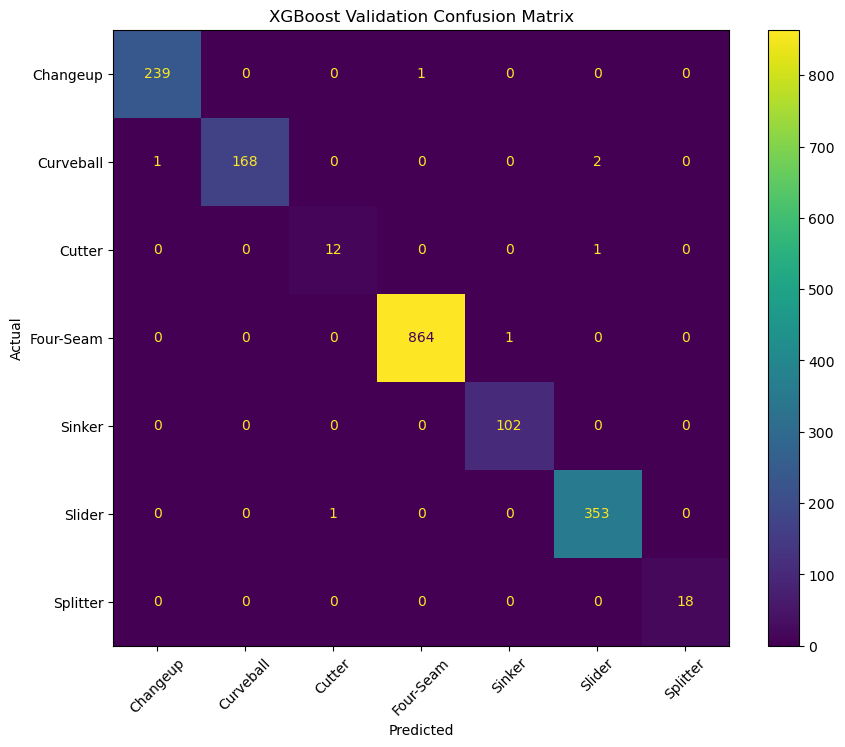

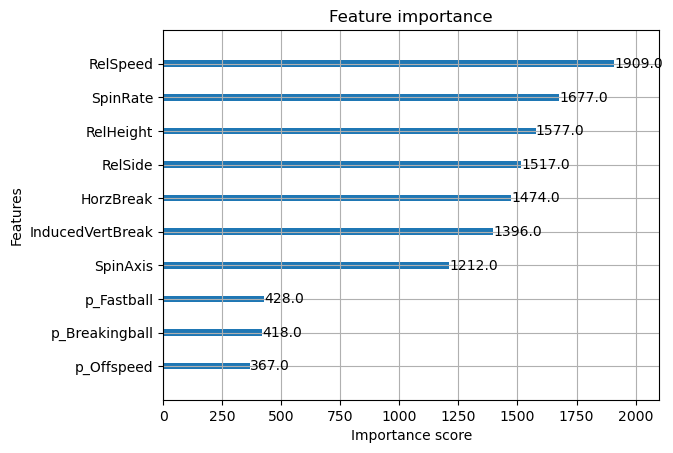

In [ ]:
rhp_indiv_xgb = xgboost_model_indiv(indiv_X_rhp, indiv_y_rhp)

In [ ]:
joblib.dump(lhp_indiv_xgb, "lhp_indiv_xgb.pkl")
lhp_indiv_xgb = joblib.load("lhp_indiv_xgb.pkl")
display(lhp_indiv_xgb)

joblib.dump(rhp_indiv_xgb, "rhp_indiv_xgb.pkl")
rhp_indiv_xgb = joblib.load("rhp_indiv_xgb.pkl")
display(rhp_indiv_xgb)

NameError: name 'lhp_indiv_xgb' is not defined

In [ ]:
def prob_indiv_df(model, df, handedness, label_col="TaggedPitchType"):
    """
    
    """
    df = df[df['PitcherThrows'] == handedness].reset_index(drop=True).copy()
    X_pred = df.copy()
    
    X_pred = (X_pred[['RelSpeed', 'SpinRate', 'SpinAxis', 'InducedVertBreak', 'HorzBreak', 'RelHeight', 'RelSide']].transform(lambda x: (x - x.mean()) / x.std()))

    X_pred.loc[:, 'p_Breakingball'] = df['p_Breakingball']
    X_pred.loc[:, 'p_Fastball'] = df['p_Fastball']
    X_pred.loc[:, 'p_Offspeed'] = df['p_Offspeed']

    cat_dtype = training_data[label_col].astype('category')
    code_to_label = dict(enumerate(cat_dtype.cat.categories))
    class_labels = [code_to_label[c] for c in model.classes_]

    probs = model.predict_proba(X_pred.values)
    probs_df = pd.DataFrame(probs, columns=[f"p_{c}" for c in class_labels])
    probs_df = probs_df.round(3)

    df_w_prob = pd.concat([df, probs_df], axis=1)
    
    return df_w_prob

In [ ]:
test_indiv_data = merged_df[merged_df['TaggedPitchType'] != merged_df['AutoPitchType']].reset_index(drop=True).copy()
test_indiv_data

,PitchNo,Date,Time,PAofInning,PitchofPA,Pitcher,PitcherId,PitcherThrows,PitcherTeam,Batter,BatterId,BatterSide,BatterTeam,PitcherSet,Inning,Top/Bottom,Outs,Balls,Strikes,TaggedPitchType,AutoPitchType,PitchCall,KorBB,TaggedHitType,PlayResult,OutsOnPlay,RunsScored,RelSpeed,VertRelAngle,HorzRelAngle,SpinRate,SpinAxis,Tilt,RelHeight,RelSide,Extension,VertBreak,InducedVertBreak,HorzBreak,PlateLocHeight,PlateLocSide,ZoneSpeed,VertApprAngle,HorzApprAngle,ZoneTime,ExitSpeed,Angle,Direction,HitSpinRate,PositionAt110X,PositionAt110Y,PositionAt110Z,Distance,LastTrackedDistance,Bearing,HangTime,pfxx,pfxz,x0,y0,z0,vx0,vy0,vz0,ax0,ay0,az0,HomeTeam,AwayTeam,Stadium,Level,League,GameID,PitchUID,EffectiveVelo,MaxHeight,MeasuredDuration,SpeedDrop,PitchLastMeasuredX,PitchLastMeasuredY,PitchLastMeasuredZ,ContactPositionX,ContactPositionY,ContactPositionZ,GameUID,UTCDate,UTCTime,LocalDateTime,UTCDateTime,AutoHitType,System,GameForeignID,Catcher,CatcherId,CatcherThrows,CatcherTeam,PlayID,PitchTrajectoryXc0,PitchTrajectoryXc1,PitchTrajectoryXc2,PitchTrajectoryYc0,PitchTrajectoryYc1,PitchTrajectoryYc2,PitchTrajectoryZc0,PitchTrajectoryZc1,PitchTrajectoryZc2,HitSpinAxis,HitTrajectoryXc0,HitTrajectoryXc1,HitTrajectoryXc2,HitTrajectoryXc3,HitTrajectoryXc4,HitTrajectoryXc5,HitTrajectoryXc6,HitTrajectoryXc7,HitTrajectoryXc8,HitTrajectoryYc0,HitTrajectoryYc1,HitTrajectoryYc2,HitTrajectoryYc3,HitTrajectoryYc4,HitTrajectoryYc5,HitTrajectoryYc6,HitTrajectoryYc7,HitTrajectoryYc8,HitTrajectoryZc0,HitTrajectoryZc1,HitTrajectoryZc2,HitTrajectoryZc3,HitTrajectoryZc4,HitTrajectoryZc5,HitTrajectoryZc6,HitTrajectoryZc7,HitTrajectoryZc8,ThrowSpeed,PopTime,ExchangeTime,TimeToBase,CatchPositionX,CatchPositionY,CatchPositionZ,ThrowPositionX,ThrowPositionY,ThrowPositionZ,BasePositionX,BasePositionY,BasePositionZ,ThrowTrajectoryXc0,ThrowTrajectoryXc1,ThrowTrajectoryXc2,ThrowTrajectoryYc0,ThrowTrajectoryYc1,ThrowTrajectoryYc2,ThrowTrajectoryZc0,ThrowTrajectoryZc1,ThrowTrajectoryZc2,PitchReleaseConfidence,PitchLocationConfidence,PitchMovementConfidence,HitLaunchConfidence,HitLandingConfidence,CatcherThrowCatchConfidence,CatcherThrowReleaseConfidence,CatcherThrowLocationConfidence,TaggedGroup,AutoGroup,p_Breakingball,p_Fastball,p_Offspeed
0,17,2025-02-21,14:11:28.90,1,2,"Walton, Ryker",1.028884e+07,1,EKU_COL,"Sanford, Mitchell",6.894070e+05,Left,OLE_REB,Undefined,1,Bottom,0,0,1,Four-Seam,Sinker,BallCalled,Undefined,Undefined,Undefined,0,0,91.33341,-2.816226,-2.792579,2047.277805,223.347860,1:30,5.76786,1.81151,6.09892,-16.98749,16.37654,14.42918,1.74231,0.42904,83.43171,-6.043673,-0.195299,0.415729,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-8.20339,9.56292,-1.60374,50.0,5.54163,5.84703,-132.43500,-7.01774,-14.55291,28.57963,-15.20932,OLE_REB,EKU_COL,OleMiss,D1,SEC,20250221-OleMiss-1,09570730-f090-11ef-b516-25f8a7d41699,90.66583,NaN,NaN,7.90170,NaN,NaN,NaN,NaN,NaN,NaN,31986fae-7fd7-49fb-892d-0c9b3ed15b06,2025-02-21,20:11:28.90,2025-02-21T14:11:28.9018368-06:00,2025-02-21T20:11:28.9018368Z,NaN,v3,21 February 2025 17:00-ekentucky@olemiss,"Duffield, Hayden",1.000078e+09,Right,EKU_COL,938d3dfa-578f-4268-93a3-aa8d2a0b0d7e,54.40126,-133.38142,14.28982,5.76568,-6.51408,-7.60466,-1.80534,6.32895,-7.27645,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,High,High,High,NaN,NaN,NaN,NaN,NaN,Fastball,Fastball,0.000,1.000,0.000
1,19,2025-02-21,14:12:00.87,1,4,"Walton, Ryker",1.028884e+07,1,EKU_COL,"Sanford, Mitchell",6.894070e+05,Left,OLE_REB,Undefined,1,Bottom,0,2,1,Four-Seam,Sinker,InPlay,Undefined,GroundBall,Out,1,0,89.88925,-2.068730,-1.714872,2175.680699,227.578542,1:30,5.66766,1.73860,6.01795,-19.82875,14.70902,14.85438,2.09728,1.38748,82.01262,-5.811790,0.957902,0.422979,60.16180,-66.419896,19.253788,NaN,NaN,NaN,NaN,1.22880,1.22880,-68.373974,0.023608,-8.14071,8.50575,-1.61221,50.0,5.49457,3.28482,-130.47528,-5.32263,-13.98214,28.386

In [ ]:
prob_indiv_df(lhp_indiv_xgb, test_indiv_data, 0)

,PitchNo,Date,Time,PAofInning,PitchofPA,Pitcher,PitcherId,PitcherThrows,PitcherTeam,Batter,BatterId,BatterSide,BatterTeam,PitcherSet,Inning,Top/Bottom,Outs,Balls,Strikes,TaggedPitchType,AutoPitchType,PitchCall,KorBB,TaggedHitType,PlayResult,OutsOnPlay,RunsScored,RelSpeed,VertRelAngle,HorzRelAngle,SpinRate,SpinAxis,Tilt,RelHeight,RelSide,Extension,VertBreak,InducedVertBreak,HorzBreak,PlateLocHeight,PlateLocSide,ZoneSpeed,VertApprAngle,HorzApprAngle,ZoneTime,ExitSpeed,Angle,Direction,HitSpinRate,PositionAt110X,PositionAt110Y,PositionAt110Z,Distance,LastTrackedDistance,Bearing,HangTime,pfxx,pfxz,x0,y0,z0,vx0,vy0,vz0,ax0,ay0,az0,HomeTeam,AwayTeam,Stadium,Level,League,GameID,PitchUID,EffectiveVelo,MaxHeight,MeasuredDuration,SpeedDrop,PitchLastMeasuredX,PitchLastMeasuredY,PitchLastMeasuredZ,ContactPositionX,ContactPositionY,ContactPositionZ,GameUID,UTCDate,UTCTime,LocalDateTime,UTCDateTime,AutoHitType,System,GameForeignID,Catcher,CatcherId,CatcherThrows,CatcherTeam,PlayID,PitchTrajectoryXc0,PitchTrajectoryXc1,PitchTrajectoryXc2,PitchTrajectoryYc0,PitchTrajectoryYc1,PitchTrajectoryYc2,PitchTrajectoryZc0,PitchTrajectoryZc1,PitchTrajectoryZc2,HitSpinAxis,HitTrajectoryXc0,HitTrajectoryXc1,HitTrajectoryXc2,HitTrajectoryXc3,HitTrajectoryXc4,HitTrajectoryXc5,HitTrajectoryXc6,HitTrajectoryXc7,HitTrajectoryXc8,HitTrajectoryYc0,HitTrajectoryYc1,HitTrajectoryYc2,HitTrajectoryYc3,HitTrajectoryYc4,HitTrajectoryYc5,HitTrajectoryYc6,HitTrajectoryYc7,HitTrajectoryYc8,HitTrajectoryZc0,HitTrajectoryZc1,HitTrajectoryZc2,HitTrajectoryZc3,HitTrajectoryZc4,HitTrajectoryZc5,HitTrajectoryZc6,HitTrajectoryZc7,HitTrajectoryZc8,ThrowSpeed,PopTime,ExchangeTime,TimeToBase,CatchPositionX,CatchPositionY,CatchPositionZ,ThrowPositionX,ThrowPositionY,ThrowPositionZ,BasePositionX,BasePositionY,BasePositionZ,ThrowTrajectoryXc0,ThrowTrajectoryXc1,ThrowTrajectoryXc2,ThrowTrajectoryYc0,ThrowTrajectoryYc1,ThrowTrajectoryYc2,ThrowTrajectoryZc0,ThrowTrajectoryZc1,ThrowTrajectoryZc2,PitchReleaseConfidence,PitchLocationConfidence,PitchMovementConfidence,HitLaunchConfidence,HitLandingConfidence,CatcherThrowCatchConfidence,CatcherThrowReleaseConfidence,CatcherThrowLocationConfidence,TaggedGroup,AutoGroup,p_Breakingball,p_Fastball,p_Offspeed,p_Changeup,p_Curveball,p_Cutter,p_Four-Seam,p_Sinker,p_Slider,p_Splitter
0,1,2025-02-21,14:02:52.36,1,1,"Elliott, Hunter",6.955450e+05,0,OLE_REB,"Bejarano, Mauricio",1.000329e+09,Right,EKU_COL,Undefined,1,Top,0,0,0,Four-Seam,Sinker,StrikeCalled,Undefined,Undefined,Undefined,0,0,89.33355,-0.276997,4.350026,2203.614887,132.167696,10:30,5.22699,-2.68740,6.21670,-17.99422,17.21702,-17.58678,3.47110,-0.13083,80.25956,-3.747010,1.186737,0.427083,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,10.39816,9.33898,2.36887,50.0,5.19704,-9.08953,-129.30922,-1.10744,17.34646,30.66937,-16.59455,OLE_REB,EKU_COL,OleMiss,D1,SEC,20250221-OleMiss-1,d5791800-f08e-11ef-b516-25f8a7d41699,88.25556,NaN,NaN,9.07400,NaN,NaN,NaN,NaN,NaN,NaN,31986fae-7fd7-49fb-892d-0c9b3ed15b06,2025-02-21,20:02:52.36,2025-02-21T14:02:52.3694080-06:00,2025-02-21T20:02:52.3694080Z,NaN,v3,21 February 2025 17:00-ekentucky@olemiss,"Smithwick, Campbell",805802.0,Right,OLE_REB,ebd6f9a4-d844-4b8f-9733-c22c00229021,54.28077,-130.32058,15.33469,5.22454,-0.56022,-8.29728,2.67804,-9.66155,8.67323,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,High,High,High,NaN,NaN,NaN,NaN,NaN,Fastball,Fastball,0.000,1.000,0.000,0.000,0.000,0.000,0.899,0.100,0.000,0.000
1,2,2025-02-21,14:03:10.24,1,2,"Elliott, Hunter",6.955450e+05,0,OLE_REB,"Bejarano, Mauricio",1.000329e+09,Right,EKU_COL,Undefined,1,Top,0,0,1,Four-Seam,Sinker,BallCalled,Undefined,Undefined,Undefined,0,0,88.90840,-2.228576,3.686879,2183.741757,129.629962,10:15,5.21500,-2.74463,6.52932,-18.22198,17.10166,-18.99836,1.64677,-0.94085,79.64732,-5.761843,0.242888,0.427764,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N

In [ ]:
prob_indiv_df(rhp_indiv_xgb, test_indiv_data, 1)

,PitchNo,Date,Time,PAofInning,PitchofPA,Pitcher,PitcherId,PitcherThrows,PitcherTeam,Batter,BatterId,BatterSide,BatterTeam,PitcherSet,Inning,Top/Bottom,Outs,Balls,Strikes,TaggedPitchType,AutoPitchType,PitchCall,KorBB,TaggedHitType,PlayResult,OutsOnPlay,RunsScored,RelSpeed,VertRelAngle,HorzRelAngle,SpinRate,SpinAxis,Tilt,RelHeight,RelSide,Extension,VertBreak,InducedVertBreak,HorzBreak,PlateLocHeight,PlateLocSide,ZoneSpeed,VertApprAngle,HorzApprAngle,ZoneTime,ExitSpeed,Angle,Direction,HitSpinRate,PositionAt110X,PositionAt110Y,PositionAt110Z,Distance,LastTrackedDistance,Bearing,HangTime,pfxx,pfxz,x0,y0,z0,vx0,vy0,vz0,ax0,ay0,az0,HomeTeam,AwayTeam,Stadium,Level,League,GameID,PitchUID,EffectiveVelo,MaxHeight,MeasuredDuration,SpeedDrop,PitchLastMeasuredX,PitchLastMeasuredY,PitchLastMeasuredZ,ContactPositionX,ContactPositionY,ContactPositionZ,GameUID,UTCDate,UTCTime,LocalDateTime,UTCDateTime,AutoHitType,System,GameForeignID,Catcher,CatcherId,CatcherThrows,CatcherTeam,PlayID,PitchTrajectoryXc0,PitchTrajectoryXc1,PitchTrajectoryXc2,PitchTrajectoryYc0,PitchTrajectoryYc1,PitchTrajectoryYc2,PitchTrajectoryZc0,PitchTrajectoryZc1,PitchTrajectoryZc2,HitSpinAxis,HitTrajectoryXc0,HitTrajectoryXc1,HitTrajectoryXc2,HitTrajectoryXc3,HitTrajectoryXc4,HitTrajectoryXc5,HitTrajectoryXc6,HitTrajectoryXc7,HitTrajectoryXc8,HitTrajectoryYc0,HitTrajectoryYc1,HitTrajectoryYc2,HitTrajectoryYc3,HitTrajectoryYc4,HitTrajectoryYc5,HitTrajectoryYc6,HitTrajectoryYc7,HitTrajectoryYc8,HitTrajectoryZc0,HitTrajectoryZc1,HitTrajectoryZc2,HitTrajectoryZc3,HitTrajectoryZc4,HitTrajectoryZc5,HitTrajectoryZc6,HitTrajectoryZc7,HitTrajectoryZc8,ThrowSpeed,PopTime,ExchangeTime,TimeToBase,CatchPositionX,CatchPositionY,CatchPositionZ,ThrowPositionX,ThrowPositionY,ThrowPositionZ,BasePositionX,BasePositionY,BasePositionZ,ThrowTrajectoryXc0,ThrowTrajectoryXc1,ThrowTrajectoryXc2,ThrowTrajectoryYc0,ThrowTrajectoryYc1,ThrowTrajectoryYc2,ThrowTrajectoryZc0,ThrowTrajectoryZc1,ThrowTrajectoryZc2,PitchReleaseConfidence,PitchLocationConfidence,PitchMovementConfidence,HitLaunchConfidence,HitLandingConfidence,CatcherThrowCatchConfidence,CatcherThrowReleaseConfidence,CatcherThrowLocationConfidence,TaggedGroup,AutoGroup,p_Breakingball,p_Fastball,p_Offspeed,p_Changeup,p_Curveball,p_Cutter,p_Four-Seam,p_Sinker,p_Slider,p_Splitter
0,17,2025-02-21,14:11:28.90,1,2,"Walton, Ryker",10288839.0,1,EKU_COL,"Sanford, Mitchell",6.894070e+05,Left,OLE_REB,Undefined,1,Bottom,0,0,1,Four-Seam,Sinker,BallCalled,Undefined,Undefined,Undefined,0,0,91.33341,-2.816226,-2.792579,2047.277805,223.347860,1:30,5.76786,1.81151,6.09892,-16.98749,16.37654,14.42918,1.74231,0.42904,83.43171,-6.043673,-0.195299,0.415729,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-8.20339,9.56292,-1.60374,50.0,5.54163,5.84703,-132.43500,-7.01774,-14.55291,28.57963,-15.20932,OLE_REB,EKU_COL,OleMiss,D1,SEC,20250221-OleMiss-1,09570730-f090-11ef-b516-25f8a7d41699,90.66583,NaN,NaN,7.90170,NaN,NaN,NaN,NaN,NaN,NaN,31986fae-7fd7-49fb-892d-0c9b3ed15b06,2025-02-21,20:11:28.90,2025-02-21T14:11:28.9018368-06:00,2025-02-21T20:11:28.9018368Z,NaN,v3,21 February 2025 17:00-ekentucky@olemiss,"Duffield, Hayden",1.000078e+09,Right,EKU_COL,938d3dfa-578f-4268-93a3-aa8d2a0b0d7e,54.40126,-133.38142,14.28982,5.76568,-6.51408,-7.60466,-1.80534,6.32895,-7.27645,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,High,High,High,NaN,NaN,NaN,NaN,NaN,Fastball,Fastball,0.000,1.000,0.000,0.000,0.0,0.0,1.000,0.000,0.0,0.0
1,19,2025-02-21,14:12:00.87,1,4,"Walton, Ryker",10288839.0,1,EKU_COL,"Sanford, Mitchell",6.894070e+05,Left,OLE_REB,Undefined,1,Bottom,0,2,1,Four-Seam,Sinker,InPlay,Undefined,GroundBall,Out,1,0,89.88925,-2.068730,-1.714872,2175.680699,227.578542,1:30,5.66766,1.73860,6.01795,-19.82875,14.70902,14.85438,2.09728,1.38748,82.01262,-5.811790,0.957902,0.422979,60.16180,-66.419896,19.253788,NaN,NaN,NaN,NaN,1.22880,1.22880,

In [ ]:
merged_trackman_games = (pd.concat([prob_indiv_df(rhp_indiv_xgb, training_data_indiv, 1), prob_indiv_df(lhp_indiv_xgb, training_data_indiv, 0), 
                                    prob_indiv_df(rhp_indiv_xgb, test_indiv_data, 1), prob_indiv_df(lhp_indiv_xgb, test_indiv_data, 0)])
                         .reset_index(drop=True)
                         .copy()
                         )
prob_cols = ["p_Changeup", "p_Curveball", "p_Cutter", "p_Four-Seam", "p_Sinker", "p_Slider", "p_Splitter"]
group_prob_cols = ['p_Breakingball', 'p_Fastball', 'p_Offspeed']
merged_trackman_games.loc[:, "predTaggedGroup"] = merged_trackman_games[group_prob_cols].idxmax(axis=1)
merged_trackman_games.loc[:, "predTaggedGroup"] = merged_trackman_games["predTaggedGroup"].apply(lambda x: str(x.split('_')[1]))
merged_trackman_games.loc[:, "predTaggedPitch"] = merged_trackman_games[prob_cols].idxmax(axis=1)
merged_trackman_games.loc[:, "predTaggedPitch"] = merged_trackman_games["predTaggedPitch"].apply(lambda x: str(x.split('_')[1]))

In [ ]:
merged_trackman_games.to_csv('../../Files/pitch_class_trackman_games.csv')

https://medium.com/mlb-technology/mlb-pitch-classification-64a1e32ee079

# Unsupervised Classification Effort

Step by Step:

- Normalize handedness metrics (RelSide and HorzBreak) to create a bigger cluster
- Gather features
- Clean data for obvious outlier pitches
- Standardize metrics - per pitcher for gmm, globally for supervised 
- Use GMM, combined with BIC to iterate through the different k's (# of clusters or different pitch types)

In [2]:
#Necessary libraries
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.impute import SimpleImputer
from sklearn.mixture import GaussianMixture
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
pd.set_option('display.float_format', '{:.3f}'.format)

In [3]:
master_trackman = pd.read_csv('../../Trackman CSV Files/merged_trackman_games.csv')

id_cols = ['Pitcher', 'PitchUID']
feature_cols = ['RelSpeed', 'SpinRate', 'SpinAxis', 'InducedVertBreak', 'HorzBreak', 'VertApprAngle', 'HorzApprAngle']

master_trackman

/var/folders/bp/l1vb_64s6tj40wftrxyjhnfm0000gn/T/ipykernel_13578/2526711866.py:1: DtypeWarning: Columns (91,92) have mixed types. Specify dtype option on import or set low_memory=False.
  master_trackman = pd.read_csv('../../Trackman CSV Files/merged_trackman_games.csv')


,PitchNo,Date,Time,PAofInning,PitchofPA,Pitcher,PitcherId,PitcherThrows,PitcherTeam,Batter,BatterId,BatterSide,BatterTeam,PitcherSet,Inning,Top/Bottom,Outs,Balls,Strikes,TaggedPitchType,AutoPitchType,PitchCall,KorBB,TaggedHitType,PlayResult,OutsOnPlay,RunsScored,RelSpeed,VertRelAngle,HorzRelAngle,SpinRate,SpinAxis,Tilt,RelHeight,RelSide,Extension,VertBreak,InducedVertBreak,HorzBreak,PlateLocHeight,PlateLocSide,ZoneSpeed,VertApprAngle,HorzApprAngle,ZoneTime,ExitSpeed,Angle,Direction,HitSpinRate,PositionAt110X,PositionAt110Y,PositionAt110Z,Distance,LastTrackedDistance,Bearing,HangTime,pfxx,pfxz,x0,y0,z0,vx0,vy0,vz0,ax0,ay0,az0,HomeTeam,AwayTeam,Stadium,Level,League,GameID,PitchUID,EffectiveVelo,MaxHeight,MeasuredDuration,SpeedDrop,PitchLastMeasuredX,PitchLastMeasuredY,PitchLastMeasuredZ,ContactPositionX,ContactPositionY,ContactPositionZ,GameUID,UTCDate,UTCTime,LocalDateTime,UTCDateTime,AutoHitType,System,HomeTeamForeignID,AwayTeamForeignID,GameForeignID,Catcher,CatcherId,CatcherThrows,CatcherTeam,PlayID,PitchTrajectoryXc0,PitchTrajectoryXc1,PitchTrajectoryXc2,PitchTrajectoryYc0,PitchTrajectoryYc1,PitchTrajectoryYc2,PitchTrajectoryZc0,PitchTrajectoryZc1,PitchTrajectoryZc2,HitSpinAxis,HitTrajectoryXc0,HitTrajectoryXc1,HitTrajectoryXc2,HitTrajectoryXc3,HitTrajectoryXc4,HitTrajectoryXc5,HitTrajectoryXc6,HitTrajectoryXc7,HitTrajectoryXc8,HitTrajectoryYc0,HitTrajectoryYc1,HitTrajectoryYc2,HitTrajectoryYc3,HitTrajectoryYc4,HitTrajectoryYc5,HitTrajectoryYc6,HitTrajectoryYc7,HitTrajectoryYc8,HitTrajectoryZc0,HitTrajectoryZc1,HitTrajectoryZc2,HitTrajectoryZc3,HitTrajectoryZc4,HitTrajectoryZc5,HitTrajectoryZc6,HitTrajectoryZc7,HitTrajectoryZc8,ThrowSpeed,PopTime,ExchangeTime,TimeToBase,CatchPositionX,CatchPositionY,CatchPositionZ,ThrowPositionX,ThrowPositionY,ThrowPositionZ,BasePositionX,BasePositionY,BasePositionZ,ThrowTrajectoryXc0,ThrowTrajectoryXc1,ThrowTrajectoryXc2,ThrowTrajectoryYc0,ThrowTrajectoryYc1,ThrowTrajectoryYc2,ThrowTrajectoryZc0,ThrowTrajectoryZc1,ThrowTrajectoryZc2,PitchReleaseConfidence,PitchLocationConfidence,PitchMovementConfidence,HitLaunchConfidence,HitLandingConfidence,CatcherThrowCatchConfidence,CatcherThrowReleaseConfidence,CatcherThrowLocationConfidence
0,1,2025-04-08,19:04:21.64,1,1,"Gilbert, Bradley",831228.000,Right,WAS_HUS,"Ishikawa, Keni",1000274623.000,Left,SEA_RED,Undefined,1,Top,0,0,0,Fastball,Four-Seam,BallCalled,Undefined,Undefined,Undefined,0,0,90.028,-3.297,-1.239,2497.732,193.681,12:30,5.621,0.511,5.836,-16.091,18.231,4.190,1.212,-0.291,83.110,-6.327,-0.487,0.422,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-2.464,10.486,-0.412,50.000,5.343,2.650,-130.679,-8.016,-4.300,25.182,-13.875,WAS_HUS,SEA_RED,UofWashington,D1,BIG10,20250408-UofWashington-1,18b54860-14e7-11f0-938f-b5417cf72451,89.392,NaN,NaN,6.918,NaN,NaN,NaN,NaN,NaN,NaN,6547872e-3314-45b6-a0d2-1680b11cc799,2025-04-09,02:04:21.64,2025-04-08T19:04:21.6401920-07:00,2025-04-09T02:04:21.6401920Z,NaN,v3,471486.000,4504,08 April 2025 21:05-seattleu@washington,"Blanchard, Colin",1000114026.000,Right,WAS_HUS,69bcc3f1-572b-4f97-8e16-e8d65a83174d,54.663,-131.575,12.591,5.619,-7.522,-6.938,-0.509,2.803,-2.150,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,High,High,High,NaN,NaN,NaN,NaN,NaN
1,2,2025-04-08,19:04:34.59,1,2,"Gilbert, Bradley",831228.000,Right,WAS_HUS,"Ishikawa, Keni",1000274623.000,Left,SEA_RED,Undefined,1,Top,0,1,0,Slider,Slider,BallCalled,Undefined,Undefined,Undefined,0,0,82.168,1.676,-0.415,2782.722,155.127,11:15,5.534,0.742,4.993,-35.984,6.645,-2.488,4.118,0.142,75.363,-4.887,-0.854,0.470,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.118,3.249,-0.700,50.000,5.666,0.972,-119.219,2.169,1.617,21.828,-27.474,WAS_HUS,SEA_RED,UofWashington,D1,BIG10,20250408-UofWashington-1,205779d0-14e7-11f0-938f-b5417cf72451,80.211,NaN,NaN,6.805,NaN,NaN,NaN,NaN,NaN,NaN,6547872e-3314-45b6-a0d2-1680b11cc799,2025-

## Helper Functions

In [5]:
## makes lefty metrics into righty metrics to make it one big model
## can probably find a more efficient way to do thsi

def mirror_handedness(row):
    
    # Encode 0 to LHP and 1 to RHP
    row['handedness_encode'] = int(row['PitcherThrows'] == 'Right')
    
    # Mirror if left
    if row['handedness_encode'] == 0: 
        row['HorzBreak'] *= -1
        row['RelSide'] *= -1
        row['HorzApprAngle'] *= -1
    return row

encoded_trackman = master_trackman.apply(mirror_handedness, axis = 1)
encoded_trackman

## filters against pitches with outlierish metrics
def clean_outliers(df):
    
    ## clean outliers and NaN cases

    # group by pitcher, pitch type for mean
    df_mean = df.groupby(['Pitcher', 'TaggedPitchType'])[feature_cols].mean().reset_index()

    # group by pitcher, pitch type for standard dev
    df_std = df.groupby(['Pitcher', 'TaggedPitchType'])[feature_cols].std().reset_index()

    pitcher_info = df_mean.merge(df_std, on = ['Pitcher', 'TaggedPitchType'], how = 'inner', suffixes = ('_mean', '_std'))
    # Clean out pitches with metrics outside of 3 SDs from the mean
    temp_trackman = df.merge(pitcher_info, on = ['Pitcher', 'TaggedPitchType'], how = 'inner')
    valid_trackman = temp_trackman[
        ((temp_trackman['RelSpeed'] >= temp_trackman['RelSpeed_mean'] - (3 * temp_trackman['RelSpeed_std'])) & 
        (temp_trackman['RelSpeed'] <= temp_trackman['RelSpeed_mean'] + (3 * temp_trackman['RelSpeed_std']))) & 
        ((temp_trackman['SpinRate'] >= temp_trackman['SpinRate_mean'] - (3 * temp_trackman['SpinRate_std'])) & 
        (temp_trackman['SpinRate'] <= temp_trackman['SpinRate_mean'] + (3 * temp_trackman['SpinRate_std']))) & 
        ((temp_trackman['SpinAxis'] >= temp_trackman['SpinAxis_mean'] - (3 * temp_trackman['SpinAxis_std'])) & 
        (temp_trackman['SpinAxis'] <= temp_trackman['SpinAxis_mean'] + (3 * temp_trackman['SpinAxis_std']))) & 
        ((temp_trackman['RelHeight'] < 8) & (temp_trackman['RelHeight'] > 3.5)) & 
        ((temp_trackman['RelSide'] < 7) & (temp_trackman['RelSide'] > -2)) &
        ((temp_trackman['InducedVertBreak'] >= temp_trackman['InducedVertBreak_mean'] - (3 * temp_trackman['InducedVertBreak_std'])) & 
        (temp_trackman['InducedVertBreak'] <= temp_trackman['InducedVertBreak_mean'] + (3 * temp_trackman['InducedVertBreak_std']))) & 
        ((temp_trackman['HorzBreak'] >= temp_trackman['HorzBreak_mean'] - (3 * temp_trackman['HorzBreak_std'])) & 
        (temp_trackman['HorzBreak'] <= temp_trackman['HorzBreak_mean'] + (3 * temp_trackman['HorzBreak_std']))) &
        ((temp_trackman['VertApprAngle'] < 0) & (temp_trackman['VertApprAngle'] > -15))]
    
    return valid_trackman

clean_trackman = clean_outliers(encoded_trackman)
clean_trackman
        

,PitchNo,Date,Time,PAofInning,PitchofPA,Pitcher,PitcherId,PitcherThrows,PitcherTeam,Batter,BatterId,BatterSide,BatterTeam,PitcherSet,Inning,Top/Bottom,Outs,Balls,Strikes,TaggedPitchType,AutoPitchType,PitchCall,KorBB,TaggedHitType,PlayResult,OutsOnPlay,RunsScored,RelSpeed,VertRelAngle,HorzRelAngle,SpinRate,SpinAxis,Tilt,RelHeight,RelSide,Extension,VertBreak,InducedVertBreak,HorzBreak,PlateLocHeight,PlateLocSide,ZoneSpeed,VertApprAngle,HorzApprAngle,ZoneTime,ExitSpeed,Angle,Direction,HitSpinRate,PositionAt110X,PositionAt110Y,PositionAt110Z,Distance,LastTrackedDistance,Bearing,HangTime,pfxx,pfxz,x0,y0,z0,vx0,vy0,vz0,ax0,ay0,az0,HomeTeam,AwayTeam,Stadium,Level,League,GameID,PitchUID,EffectiveVelo,MaxHeight,MeasuredDuration,SpeedDrop,PitchLastMeasuredX,PitchLastMeasuredY,PitchLastMeasuredZ,ContactPositionX,ContactPositionY,ContactPositionZ,GameUID,UTCDate,UTCTime,LocalDateTime,UTCDateTime,AutoHitType,System,HomeTeamForeignID,AwayTeamForeignID,GameForeignID,Catcher,CatcherId,CatcherThrows,CatcherTeam,PlayID,PitchTrajectoryXc0,PitchTrajectoryXc1,PitchTrajectoryXc2,PitchTrajectoryYc0,PitchTrajectoryYc1,PitchTrajectoryYc2,PitchTrajectoryZc0,PitchTrajectoryZc1,PitchTrajectoryZc2,HitSpinAxis,HitTrajectoryXc0,HitTrajectoryXc1,HitTrajectoryXc2,HitTrajectoryXc3,HitTrajectoryXc4,HitTrajectoryXc5,HitTrajectoryXc6,HitTrajectoryXc7,HitTrajectoryXc8,HitTrajectoryYc0,HitTrajectoryYc1,HitTrajectoryYc2,HitTrajectoryYc3,HitTrajectoryYc4,HitTrajectoryYc5,HitTrajectoryYc6,HitTrajectoryYc7,HitTrajectoryYc8,HitTrajectoryZc0,HitTrajectoryZc1,HitTrajectoryZc2,HitTrajectoryZc3,HitTrajectoryZc4,HitTrajectoryZc5,HitTrajectoryZc6,HitTrajectoryZc7,HitTrajectoryZc8,ThrowSpeed,PopTime,ExchangeTime,TimeToBase,CatchPositionX,CatchPositionY,CatchPositionZ,ThrowPositionX,ThrowPositionY,ThrowPositionZ,BasePositionX,BasePositionY,BasePositionZ,ThrowTrajectoryXc0,ThrowTrajectoryXc1,ThrowTrajectoryXc2,ThrowTrajectoryYc0,ThrowTrajectoryYc1,ThrowTrajectoryYc2,ThrowTrajectoryZc0,ThrowTrajectoryZc1,ThrowTrajectoryZc2,PitchReleaseConfidence,PitchLocationConfidence,PitchMovementConfidence,HitLaunchConfidence,HitLandingConfidence,CatcherThrowCatchConfidence,CatcherThrowReleaseConfidence,CatcherThrowLocationConfidence,handedness_encode,RelSpeed_mean,SpinRate_mean,SpinAxis_mean,InducedVertBreak_mean,HorzBreak_mean,VertApprAngle_mean,HorzApprAngle_mean,RelSpeed_std,SpinRate_std,SpinAxis_std,InducedVertBreak_std,HorzBreak_std,VertApprAngle_std,HorzApprAngle_std
0,1,2025-04-08,19:04:21.64,1,1,"Gilbert, Bradley",831228.000,Right,WAS_HUS,"Ishikawa, Keni",1000274623.000,Left,SEA_RED,Undefined,1,Top,0,0,0,Fastball,Four-Seam,BallCalled,Undefined,Undefined,Undefined,0,0,90.028,-3.297,-1.239,2497.732,193.681,12:30,5.621,0.511,5.836,-16.091,18.231,4.190,1.212,-0.291,83.110,-6.327,-0.487,0.422,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-2.464,10.486,-0.412,50.000,5.343,2.650,-130.679,-8.016,-4.300,25.182,-13.875,WAS_HUS,SEA_RED,UofWashington,D1,BIG10,20250408-UofWashington-1,18b54860-14e7-11f0-938f-b5417cf72451,89.392,NaN,NaN,6.918,NaN,NaN,NaN,NaN,NaN,NaN,6547872e-3314-45b6-a0d2-1680b11cc799,2025-04-09,02:04:21.64,2025-04-08T19:04:21.6401920-07:00,2025-04-09T02:04:21.6401920Z,NaN,v3,471486.000,4504,08 April 2025 21:05-seattleu@washington,"Blanchard, Colin",1000114026.000,Right,WAS_HUS,69bcc3f1-572b-4f97-8e16-e8d65a83174d,54.663,-131.575,12.591,5.619,-7.522,-6.938,-0.509,2.803,-2.150,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,High,High,High,NaN,NaN,NaN,NaN,NaN,1,88.683,2385.486,200.013,19.391,6.827,-4.734,-0.204,1.473,122.793,12.787,3.209,3.714,1.039,1.071
1,2,2025-04-08,19:04:34.59,1,2,"Gilbert, Bradley",831228.000,Right,WAS_HUS,"Ishikawa, Keni",1000274623.000,Left,SEA_RED,Undefined,1,Top,0,1,0,Slider,Slider,BallCalled,Undefined,Undefined,Undefined,0,0,82.168,1.676,-0.415,2782.722,155.127,11:15,5.534,0.742,4.993,-35.984,6.645,-2.488,4.

### GMM Functions

In [6]:
def choose_gmm(X, k_range = range(2, 10), covariance_types = ('full', 'diag')):
    #Pipeline: impute, scale, pca, gmm
    
    #Initialize bic choice to none
    best = None
    best_bic = np.inf
    best_model = None
    
    # fill all NaN cases with the pitcher's median
    imputer = SimpleImputer(strategy = 'median')
    # scale
    scaler = StandardScaler()
    
    X_proc = imputer.fit_transform(X)
    X_proc = scaler.fit_transform(X_proc)
    
    # loop through covariance types and k values to find best number of clusters and best performing gmm
    for cov in covariance_types:
        for k in k_range:
            gmm = GaussianMixture(n_components = k, covariance_type = cov, reg_covar=1e-4, n_init = 5, random_state = 42)
            gmm.fit(X_proc)
            bic = gmm.bic(X_proc)
            if bic < best_bic:
                best_bic = bic
                best = (k, cov, bic)
                best_model = (imputer, scaler, gmm)
                
    return best, best_model

def fit_gmm(X, best_model):
    
    imputer, scaler, gmm = best_model
    X_proc = imputer.transform(X)
    X_proc = scaler.transform(X_proc)
    
    resp = gmm.predict_proba(X_proc) # soft cluster memberships 
    labels = resp.argmax(axis=1) 
    return {'imputer':imputer, 'scaler':scaler, 'gmm':gmm, 'labels':labels, 'proba':resp}

In [7]:
unique_pitchers = ['King, Devon', 'Murdock, Steele', 'Davidson, Garrett', 'Weber, Chapman', 'Villar, Jake', 'Gregson, Niccolas', 'Ries, Nathan', 'Cazares, Julian', 'Remmers, Ethan', 'Pelzman, Harry']

In [18]:
def run_gmm(df):
    ucsd = df[df['PitcherTeam'] == 'CSD_TRI'][id_cols + feature_cols + ['PitcherThrows']]
    ucsd = ucsd[ucsd['Pitcher'].isin(unique_pitchers)].copy()

    results = []   # store per-pitcher cluster results
    max_clusters = 0

    for pitcher, group in ucsd.groupby('Pitcher'):
        # scale per pitcher
        scaler = StandardScaler()
        X_scaled = scaler.fit_transform(group[feature_cols])

        # choose best GMM
        best_info, best_model = choose_gmm(group[feature_cols], 
                                           k_range=range(2, 9), 
                                           covariance_types=('full', 'diag'))
        gmm_artifacts = fit_gmm(group[feature_cols], best_model)

        # add labels
        temp = group.copy()
        temp['cluster'] = gmm_artifacts['labels']

        # add cluster probability columns
        n_clusters = gmm_artifacts['proba'].shape[1]
        for c in range(n_clusters):
            temp[f'cluster_{c}_prob'] = gmm_artifacts['proba'][:, c]

        results.append(temp)
        max_clusters = max(max_clusters, n_clusters)

    # concat all pitchers
    clustered = pd.concat(results, axis=0)

    # ensure consistent columns (fill NaN where a pitcher had fewer clusters)
    for c in range(max_clusters):
        col = f'cluster_{c}_prob'
        if col not in clustered.columns:
            clustered[col] = np.nan

    prob_cols = [f'cluster_{c}_prob' for c in range(max_clusters)]
    with_clusters = clustered[['Pitcher', 'PitchUID', 'cluster'] + prob_cols]
    result = ucsd.merge(with_clusters, on = ['Pitcher', 'PitchUID'], how = 'inner')

    return result


gmm_results = run_gmm(clean_trackman)
gmm_results
    

,Pitcher,PitchUID,RelSpeed,SpinRate,SpinAxis,InducedVertBreak,HorzBreak,VertApprAngle,HorzApprAngle,PitcherThrows,cluster,cluster_0_prob,cluster_1_prob,cluster_2_prob,cluster_3_prob,cluster_4_prob,cluster_5_prob,cluster_6_prob,cluster_7_prob
0,"King, Devon",a34e3150-f190-11ef-9456-e7fd19fa9ca5,83.403,2719.426,153.647,10.244,-4.427,-6.560,-3.247,Right,1,0.000,0.980,0.000,0.020,0.000,NaN,NaN,NaN
1,"King, Devon",ade782b0-f190-11ef-9456-e7fd19fa9ca5,83.645,2739.234,125.414,5.186,-5.282,-8.171,-3.758,Right,3,0.000,0.000,0.000,1.000,0.000,NaN,NaN,NaN
2,"King, Devon",b8d95450-f190-11ef-9456-e7fd19fa9ca5,82.296,2887.042,104.049,2.769,-5.825,-8.047,-3.114,Right,3,0.000,0.000,0.000,1.000,0.000,NaN,NaN,NaN
3,"King, Devon",c3c5cec0-f190-11ef-9456-e7fd19fa9ca5,83.319,2701.642,161.655,10.821,-3.180,-5.272,-1.375,Right,1,0.000,0.999,0.000,0.001,0.000,NaN,NaN,NaN
4,"King, Devon",d51e6ba0-f190-11ef-9456-e7fd19fa9ca5,83.364,2753.131,165.777,10.145,-2.266,-5.681,-2.693,Right,1,0.000,1.000,0.000,0.000,0.000,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7235,"Pelzman, Harry",b1025ca0-02ba-11f0-a484-1deccb072780,87.961,2124.178,159.633,17.148,5.938,-4.362,-0.097,Left,3,0.000,0.000,0.000,1.000,0.000,0.000,0.000,NaN
7236,"Pelzman, Harry",b1025ca0-02ba-11f0-a484-1deccb072780,87.961,2124.178,159.633,17.148,5.938,-4.362,-0.097,Left,3,0.000,0.000,0.000,1.000,0.000,0.000,0.000,NaN
7237,"Pelzman, Harry",cc982120-02ba-11f0-a484-1deccb072780,86.797,2128.023,134.508,15.070,14.022,-5.869,-0.085,Left,2,0.000,0.000,0.908,0.092,0.000,0.000,0.000,NaN
7238,"Pelzman, Harry",cc982120-02ba-11f0-a484-1deccb072780,86.797,2128.023,134.508,15.070,14.022,-5.869,-0.085,Left,2,0.000,0.000,0.908,0.092,0.000,0.000,0.000,NaN


In [19]:
## deencode handedness metrics

def mirror_handedness(row):
    
    # Encode 0 to LHP and 1 to RHP
    row['handedness_encode'] = int(row['PitcherThrows'] == 'Right')
    
    # Mirror if left
    if row['handedness_encode'] == 0: 
        row['HorzBreak'] *= -1
        row['HorzApprAngle'] *= -1
    return row

gmm_results = gmm_results.apply(mirror_handedness, axis = 1)
gmm_results.head()

,Pitcher,PitchUID,RelSpeed,SpinRate,SpinAxis,InducedVertBreak,HorzBreak,VertApprAngle,HorzApprAngle,PitcherThrows,cluster,cluster_0_prob,cluster_1_prob,cluster_2_prob,cluster_3_prob,cluster_4_prob,cluster_5_prob,cluster_6_prob,cluster_7_prob,handedness_encode
0,"King, Devon",a34e3150-f190-11ef-9456-e7fd19fa9ca5,83.403,2719.426,153.647,10.244,-4.427,-6.560,-3.247,Right,1,0.000,0.980,0.000,0.020,0.000,NaN,NaN,NaN,1
1,"King, Devon",ade782b0-f190-11ef-9456-e7fd19fa9ca5,83.645,2739.234,125.414,5.186,-5.282,-8.171,-3.758,Right,3,0.000,0.000,0.000,1.000,0.000,NaN,NaN,NaN,1
2,"King, Devon",b8d95450-f190-11ef-9456-e7fd19fa9ca5,82.296,2887.042,104.049,2.769,-5.825,-8.047,-3.114,Right,3,0.000,0.000,0.000,1.000,0.000,NaN,NaN,NaN,1
3,"King, Devon",c3c5cec0-f190-11ef-9456-e7fd19fa9ca5,83.319,2701.642,161.655,10.821,-3.180,-5.272,-1.375,Right,1,0.000,0.999,0.000,0.001,0.000,NaN,NaN,NaN,1
4,"King, Devon",d51e6ba0-f190-11ef-9456-e7fd19fa9ca5,83.364,2753.131,165.777,10.145,-2.266,-5.681,-2.693,Right,1,0.000,1.000,0.000,0.000,0.000,NaN,NaN,NaN,1


In [20]:
ucsd_clusters = gmm_results[['Pitcher', 'PitcherThrows', 'PitchUID', 'cluster', 'cluster_0_prob', 'cluster_1_prob', 'cluster_2_prob', 'cluster_3_prob', 'cluster_4_prob', 'cluster_5_prob', 'cluster_6_prob', 'cluster_7_prob']].merge(master_trackman, on = ['Pitcher', 'PitchUID'], how = 'left')
ucsd_clusters = ucsd_clusters[['Pitcher'] + feature_cols + ['cluster', 'PitchUID']]
ucsd_clusters.head()

,Pitcher,RelSpeed,SpinRate,SpinAxis,InducedVertBreak,HorzBreak,VertApprAngle,HorzApprAngle,cluster,PitchUID
0,"King, Devon",83.403,2719.426,153.647,10.244,-4.427,-6.560,-3.247,1,a34e3150-f190-11ef-9456-e7fd19fa9ca5
1,"King, Devon",83.645,2739.234,125.414,5.186,-5.282,-8.171,-3.758,3,ade782b0-f190-11ef-9456-e7fd19fa9ca5
2,"King, Devon",82.296,2887.042,104.049,2.769,-5.825,-8.047,-3.114,3,b8d95450-f190-11ef-9456-e7fd19fa9ca5
3,"King, Devon",83.319,2701.642,161.655,10.821,-3.180,-5.272,-1.375,1,c3c5cec0-f190-11ef-9456-e7fd19fa9ca5
4,"King, Devon",83.364,2753.131,165.777,10.145,-2.266,-5.681,-2.693,1,d51e6ba0-f190-11ef-9456-e7fd19fa9ca5


In [21]:
pitch_class_probs = pd.read_csv('../../Files/pitch_class_trackman_games.csv')

ucsd_clusters = gmm_results.merge(pitch_class_probs[['Pitcher', 'PitchUID', 'p_Breakingball', 'p_Fastball', 'p_Offspeed', 'p_Changeup', 'p_Curveball', 'p_Cutter', 'p_Four-Seam', 'p_Sinker', 'p_Slider', 'p_Splitter', 'predTaggedPitch']], on = ['Pitcher', 'PitchUID'], how = 'inner')
ucsd_clusters.head()

,Pitcher,PitchUID,RelSpeed,SpinRate,SpinAxis,InducedVertBreak,HorzBreak,VertApprAngle,HorzApprAngle,PitcherThrows,cluster,cluster_0_prob,cluster_1_prob,cluster_2_prob,cluster_3_prob,cluster_4_prob,cluster_5_prob,cluster_6_prob,cluster_7_prob,handedness_encode,p_Breakingball,p_Fastball,p_Offspeed,p_Changeup,p_Curveball,p_Cutter,p_Four-Seam,p_Sinker,p_Slider,p_Splitter,predTaggedPitch
0,"King, Devon",a34e3150-f190-11ef-9456-e7fd19fa9ca5,83.403,2719.426,153.647,10.244,-4.427,-6.560,-3.247,Right,1,0.000,0.980,0.000,0.020,0.000,NaN,NaN,NaN,1,0.998,0.002,0.000,0.000,0.000,0.000,0.000,0.000,1.000,0.000,Slider
1,"King, Devon",ade782b0-f190-11ef-9456-e7fd19fa9ca5,83.645,2739.234,125.414,5.186,-5.282,-8.171,-3.758,Right,3,0.000,0.000,0.000,1.000,0.000,NaN,NaN,NaN,1,1.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,1.000,0.000,Slider
2,"King, Devon",b8d95450-f190-11ef-9456-e7fd19fa9ca5,82.296,2887.042,104.049,2.769,-5.825,-8.047,-3.114,Right,3,0.000,0.000,0.000,1.000,0.000,NaN,NaN,NaN,1,1.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,1.000,0.000,Slider
3,"King, Devon",c3c5cec0-f190-11ef-9456-e7fd19fa9ca5,83.319,2701.642,161.655,10.821,-3.180,-5.272,-1.375,Right,1,0.000,0.999,0.000,0.001,0.000,NaN,NaN,NaN,1,0.980,0.020,0.000,0.000,0.000,0.000,0.000,0.000,1.000,0.000,Slider
4,"King, Devon",d51e6ba0-f190-11ef-9456-e7fd19fa9ca5,83.364,2753.131,165.777,10.145,-2.266,-5.681,-2.693,Right,1,0.000,1.000,0.000,0.000,0.000,NaN,NaN,NaN,1,0.995,0.005,0.000,0.000,0.000,0.000,0.000,0.000,1.000,0.000,Slider


In [22]:
unique_pitchers

['King, Devon',
 'Murdock, Steele',
 'Davidson, Garrett',
 'Weber, Chapman',
 'Villar, Jake',
 'Gregson, Niccolas',
 'Ries, Nathan',
 'Cazares, Julian',
 'Remmers, Ethan',
 'Pelzman, Harry']

In [23]:
ucsd_cluster_probs = ucsd_clusters.groupby(['Pitcher', 'cluster'])[feature_cols + ['p_Changeup', 'p_Curveball', 'p_Cutter', 'p_Four-Seam', 'p_Sinker', 'p_Slider', 'p_Splitter']].mean().reset_index()
ucsd_cluster_probs

,Pitcher,cluster,RelSpeed,SpinRate,SpinAxis,InducedVertBreak,HorzBreak,VertApprAngle,HorzApprAngle,p_Changeup,p_Curveball,p_Cutter,p_Four-Seam,p_Sinker,p_Slider,p_Splitter
0,"Cazares, Julian",0,88.906,2152.632,167.643,18.784,-3.805,-5.185,-0.519,0.000,0.000,0.001,0.997,0.001,0.000,0.000
1,"Cazares, Julian",1,80.312,2396.450,277.734,0.621,5.381,-7.871,0.624,0.000,0.221,0.000,0.000,0.000,0.778,0.000
2,"Cazares, Julian",2,80.500,1797.193,93.892,3.468,-19.273,-7.665,-0.716,0.962,0.000,0.001,0.002,0.031,0.000,0.004
3,"Cazares, Julian",3,87.675,2150.195,152.411,17.684,-8.451,-5.044,-1.579,0.000,0.000,0.001,0.996,0.002,0.000,0.000
4,"Davidson, Garrett",0,85.804,2170.395,152.391,16.392,-7.990,-5.485,0.760,0.001,0.000,0.002,0.981,0.015,0.000,0.000
5,"Davidson, Garrett",1,77.730,1510.850,92.493,2.168,-11.738,-8.334,1.553,1.000,0.000,0.000,0.000,0.000,0.000,0.000
6,"Davidson, Garrett",2,73.189,2433.937,304.505,-6.857,13.505,-9.105,3.208,0.000,0.998,0.000,0.000,0.000,0.002,0.000
7,"Davidson, Garrett",3,77.118,1492.231,93.067,2.572,-16.254,-8.026,0.119,1.000,0.000,0.000,0.000,0.000,0.000,0.000
8,"Davidson, Garrett",4,83.810,2097.881,178.711,11.131,-0.911,-6.313,2.110,0.001,0.000,0.354,0.443,0.020,0.182,0.000
9,"Gregson, Niccolas",0,85.184,2405.847,164.544,10.144,-2.426,-5.656,-2.971,0.000,0.000,0.366,0.092,0.000,0.542,0.000


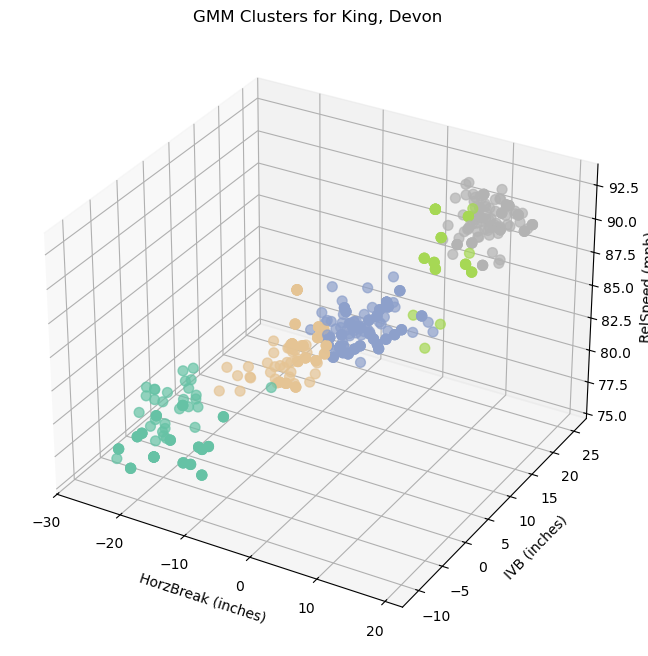

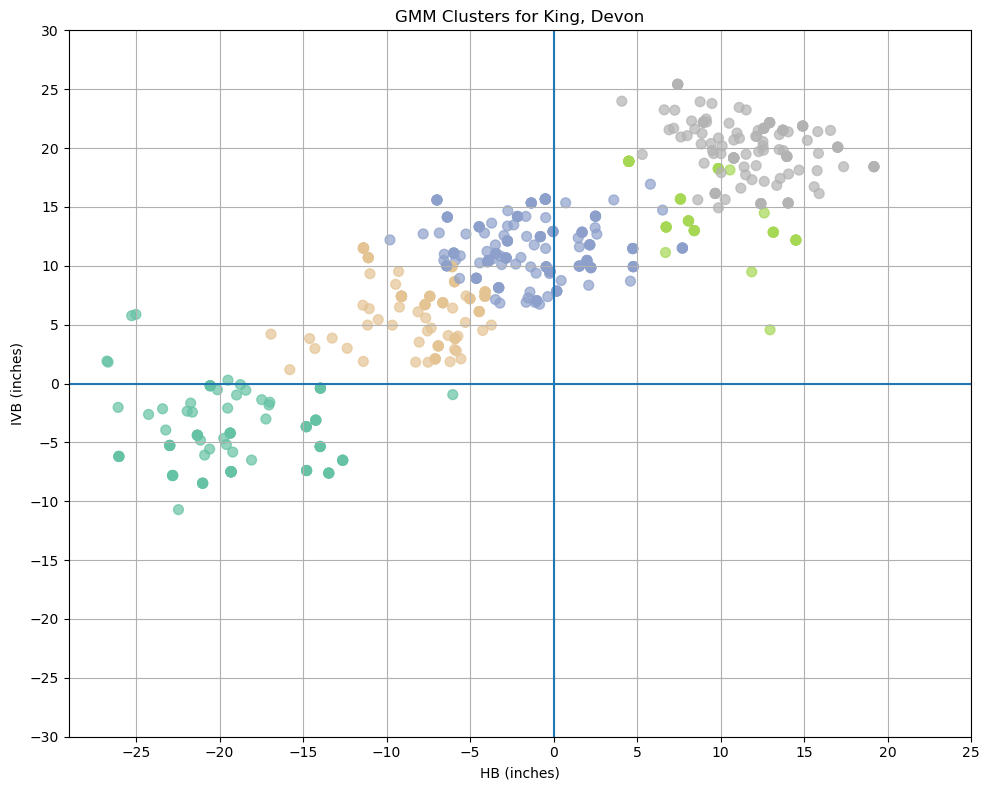

In [24]:
def plot_clusters(df, pitcher):
    
    clustered = df[df['Pitcher'] == pitcher]
    
    fig = plt.figure(figsize=(10,8))
    ax = fig.add_subplot(111, projection='3d')

    ax.scatter(
        clustered['HorzBreak'],
        clustered['InducedVertBreak'],
        clustered['RelSpeed'],
        c=clustered['cluster'],
        cmap='Set2',
        s=50,
        alpha=0.7
    )

    ax.set_xlabel('HorzBreak (inches)')
    ax.set_ylabel('IVB (inches)')
    ax.set_zlabel('RelSpeed (mph)')
    ax.set_title(f"GMM Clusters for {pitcher}")
    plt.show()

    # --- 2D Scatter Plot ---- #
    fig = plt.figure(figsize = (10,8))
    plt.scatter(
        clustered['HorzBreak'],
        clustered['InducedVertBreak'],
        c = clustered['cluster'],
        cmap = 'Set2',
        s = 50,
        alpha = 0.7
    )

    plt.xlabel('HB (inches)')
    plt.ylabel('IVB (inches)')
    plt.xticks(range(-25, 26, 5))
    plt.yticks(range(-30, 35, 5))
    plt.axhline(y = 0)
    plt.axvline(x = 0)
    plt.title(f"GMM Clusters for {pitcher}")
    plt.grid()
    plt.tight_layout()
    plt.show()
    
plot_clusters(gmm_results, 'King, Devon')
    

In [25]:
prob_columns = ['p_Changeup', 'p_Curveball', 'p_Cutter', 'p_Four-Seam', 'p_Sinker', 'p_Slider', 'p_Splitter']

def assign_primary_secondary(df, prob_columns):
    df = df.copy()
    top2 = df[prob_columns].apply(lambda row: row.nlargest(2).index, axis=1)
    df['primary_cluster'] = top2.apply(lambda idx: idx[0].split('_')[1])
    df['secondary_cluster'] = top2.apply(lambda idx: idx[1].split('_')[1])
    return df

ucsd_cluster_probs = assign_primary_secondary(ucsd_cluster_probs, prob_columns)

def clean_secondary(row):
    if row[f"p_{row['primary_cluster']}"] > 0.65:
        row['secondary_cluster'] = None
        
    return row

ucsd_cluster_probs = ucsd_cluster_probs.apply(clean_secondary, axis = 1)
display(ucsd_cluster_probs)
        
gmm_results = gmm_results.merge(ucsd_cluster_probs[['Pitcher', 'cluster', 'primary_cluster', 'secondary_cluster']], on = ['Pitcher', 'cluster'], how = 'left')

# hard code cutter as primary cluster if it is has significant p as a secondary cluster
def cutter_clean(row):
    
    if row['secondary_cluster'] == 'Cutter':
        row['primary_cluster'] = 'Cutter'
        row['secondary_cluster'] = None
    return row

gmm_results = gmm_results.apply(cutter_clean, axis = 1)
gmm_results.head()
        

,Pitcher,cluster,RelSpeed,SpinRate,SpinAxis,InducedVertBreak,HorzBreak,VertApprAngle,HorzApprAngle,p_Changeup,p_Curveball,p_Cutter,p_Four-Seam,p_Sinker,p_Slider,p_Splitter,primary_cluster,secondary_cluster
0,"Cazares, Julian",0,88.906,2152.632,167.643,18.784,-3.805,-5.185,-0.519,0.000,0.000,0.001,0.997,0.001,0.000,0.000,Four-Seam,None
1,"Cazares, Julian",1,80.312,2396.450,277.734,0.621,5.381,-7.871,0.624,0.000,0.221,0.000,0.000,0.000,0.778,0.000,Slider,None
2,"Cazares, Julian",2,80.500,1797.193,93.892,3.468,-19.273,-7.665,-0.716,0.962,0.000,0.001,0.002,0.031,0.000,0.004,Changeup,None
3,"Cazares, Julian",3,87.675,2150.195,152.411,17.684,-8.451,-5.044,-1.579,0.000,0.000,0.001,0.996,0.002,0.000,0.000,Four-Seam,None
4,"Davidson, Garrett",0,85.804,2170.395,152.391,16.392,-7.990,-5.485,0.760,0.001,0.000,0.002,0.981,0.015,0.000,0.000,Four-Seam,None
5,"Davidson, Garrett",1,77.730,1510.850,92.493,2.168,-11.738,-8.334,1.553,1.000,0.000,0.000,0.000,0.000,0.000,0.000,Changeup,None
6,"Davidson, Garrett",2,73.189,2433.937,304.505,-6.857,13.505,-9.105,3.208,0.000,0.998,0.000,0.000,0.000,0.002,0.000,Curveball,None
7,"Davidson, Garrett",3,77.118,1492.231,93.067,2.572,-16.254,-8.026,0.119,1.000,0.000,0.000,0.000,0.000,0.000,0.000,Changeup,None
8,"Davidson, Garrett",4,83.810,2097.881,178.711,11.131,-0.911,-6.313,2.110,0.001,0.000,0.354,0.443,0.020,0.182,0.000,Four-Seam,Cutter
9,"Gregson, Niccolas",0,85.184,2405.847,164.544,10.144,-2.426,-5.656,-2.971,0.000,0.000,0.366,0.092,0.000,0.542,0.000,Slider,Cutter


,Pitcher,PitchUID,RelSpeed,SpinRate,SpinAxis,InducedVertBreak,HorzBreak,VertApprAngle,HorzApprAngle,PitcherThrows,cluster,cluster_0_prob,cluster_1_prob,cluster_2_prob,cluster_3_prob,cluster_4_prob,cluster_5_prob,cluster_6_prob,cluster_7_prob,handedness_encode,primary_cluster,secondary_cluster
0,"King, Devon",a34e3150-f190-11ef-9456-e7fd19fa9ca5,83.403,2719.426,153.647,10.244,-4.427,-6.560,-3.247,Right,1,0.000,0.980,0.000,0.020,0.000,NaN,NaN,NaN,1,Cutter,None
1,"King, Devon",ade782b0-f190-11ef-9456-e7fd19fa9ca5,83.645,2739.234,125.414,5.186,-5.282,-8.171,-3.758,Right,3,0.000,0.000,0.000,1.000,0.000,NaN,NaN,NaN,1,Slider,None
2,"King, Devon",b8d95450-f190-11ef-9456-e7fd19fa9ca5,82.296,2887.042,104.049,2.769,-5.825,-8.047,-3.114,Right,3,0.000,0.000,0.000,1.000,0.000,NaN,NaN,NaN,1,Slider,None
3,"King, Devon",c3c5cec0-f190-11ef-9456-e7fd19fa9ca5,83.319,2701.642,161.655,10.821,-3.180,-5.272,-1.375,Right,1,0.000,0.999,0.000,0.001,0.000,NaN,NaN,NaN,1,Cutter,None
4,"King, Devon",d51e6ba0-f190-11ef-9456-e7fd19fa9ca5,83.364,2753.131,165.777,10.145,-2.266,-5.681,-2.693,Right,1,0.000,1.000,0.000,0.000,0.000,NaN,NaN,NaN,1,Cutter,None
